## Problem setting

Here we define the Size of the map, the number of drones used and their initial spatial distribution and the wind distribution model.

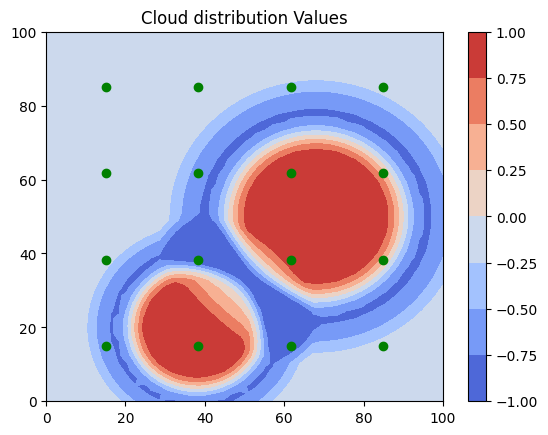

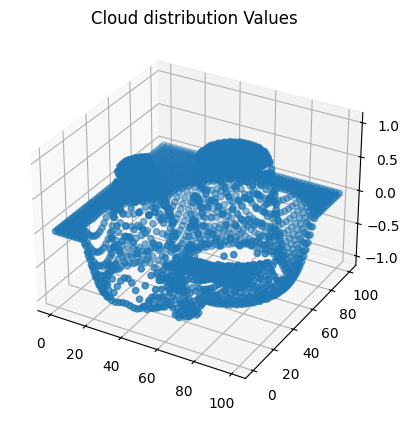

In [ ]:
# GRID DRONE POSITION
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the simulation area (e.g., a 2D grid)
area_size = 100

# Number of drones for each row, column
num_dronesx = 4
num_dronesy = 4

# Total number of drones
num_drones = num_dronesx * num_dronesy

# Distance of the grid from the border
margin = 15 / 100 * area_size

# Create a 3D grid for x, y, and z
x = np.linspace(margin, area_size - margin, num_dronesx)
y = np.linspace(margin, area_size - margin, num_dronesy)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y, z)
drone_positions = np.vstack([xv.ravel(), yv.ravel()]).T

def wind_field_2d(pos, clouds, t, winds_current):
    """
    Calculates the wind speed in the range [-1, 1] at the point (x, y)
    based on the distribution of clouds.

    Parameters:
    - x, y: 2D coordinates to evaluate the wind
    - clouds: list of clouds, each defined by (cx, cy, radius),
              where (cx, cy) is the center of the cloud and
              radius is the size of the cloud.
    - t: the time step I'm evaluating the function at.
    - winds_current: list describing the wind velocity that moves the clouds, made by [vx, vy]

    Returns:
    - wind: Vertical wind velocity at point (x, y) in the range [-1, 1].
    """

    # Initialize wind velocity
    x = pos[:,0]
    y = pos[:,1]
    # Iterate over each cloud
    for cloud in clouds:
        cx, cy, radius, height = cloud
        cx += winds_current[0]*t*0.03
        cy += winds_current[1]*t*0.03

        # Calculate horizontal distance from the cloud center
        horizontal_distance = np.sqrt((x - cx)**2 + (y - cy)**2)

        # 1. Updraft (center of the cloud) - strongest at the center and reduces outward
        wind_Updraft = np.where(horizontal_distance <= (radius*0.4) , np.exp(-(horizontal_distance**2) / (2 * radius**2)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft = np.where(np.logical_and(horizontal_distance > (radius*0.4), horizontal_distance <= (radius*0.7)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * np.cos((horizontal_distance - (radius*0.4))*np.pi/(radius*0.3)), 0)

        # 2. Downdraft (outflow at the cloud top)
        wind_Downdraft += np.where(np.logical_and(horizontal_distance > (radius*0.7), horizontal_distance <= (radius)) , np.exp(-(horizontal_distance**2) / (2 * radius**2)) * (-1)* np.cos((horizontal_distance - (radius*0.7))*np.pi/(2*radius*0.3)), 0)

        # Sum up the wind contributions from all clouds
        try:
          wind += wind_Updraft + wind_Downdraft
        except:
          wind = wind_Updraft + wind_Downdraft
    # Clamp the wind velocity to be within the range [-1, 1]
    return np.clip(wind, -1, 1)

clouds_2d = [
    (50, 50, 40, 10),
    (20, 20, 30, 10),
]
wind_direction_clouds = np.array([1,0])

x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Calculate the true function values
Z_true = wind_field_2d(XY, clouds_2d, 600, wind_direction_clouds).reshape(X.shape)

# Plot the true values
true_v = plt.contourf(X, Y, Z_true, cmap='coolwarm')
plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='green', label='Drones')
plt.colorbar(true_v)
plt.title('Cloud distribution Values')
plt.show()

# Plot the true values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z_true)
# plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='green', label='Drones')
# plt.colorbar(true_v)
plt.title('Cloud distribution Values')
plt.show()



## Kernel stochastic approximation + Old method Drone class

---



In [ ]:
# https://andrewcharlesjones.github.io/journal/nystrom-approximation.html ---theori

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

sigma_s      = 1
length_scale = 10

class model_E:
  def __init__(self, E, l, kernel=ConstantKernel(1e-2, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed"), seed = 0):
    self.E = E
    self.l = l
    np.random.seed(seed)

    self.samples = np.random.rand(self.l,2) * area_size
    self.kernel = kernel
    K = self.kernel(self.samples)
    U, D, V = np.linalg.svd(K)
    self.Lambda = np.diag(D[:E])
    self.G = U[:,:E]
    print("min{ lambda } = ", self.Lambda[-1,-1])

  def check(self):
      x = np.linspace(0, 1, 3)*area_size
      y = np.linspace(0, 1, 3)*area_size
      xy = np.vstack((x,y)).T
      m = x.shape[0]
      print(xy.shape)

      eigenfunctions = np.zeros((self.E, m))
      eigenfunctions = self.G.T @ self.kernel(self.samples, xy)

      # eigenvalues = np.eye(self.E)
      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      # eigenvalues = np.diag(diag)
      eigenvalues = self.Lambda

      K = eigenfunctions.T @ (eigenvalues) @ eigenfunctions
      print(K)

      try:
          np.linalg.cholesky(K)
          psd = True
          print("true")
      except np.linalg.LinAlgError:
          print("error")

  def __call__(self, t):
      #t must be a mx2 array
      m = t.shape[0]
      x = np.zeros((m,2))
      x = t
      Q, R = np.linalg.qr(self.G)
      self.G = Q
      eigenfunctions = np.zeros((self.E, m))
      eigenvalues = np.eye(self.E)
      eigenfunctions = self.G.T @ self.kernel(self.samples, x)
      diag = np.maximum(np.diag(self.Lambda), 1e-6)
      eigenvalues = np.diag(diag)

      return eigenfunctions, eigenvalues


In [ ]:
import time
class Drone:
    def __init__(self, position, area_size, kernel, num_drones, E, l, sigma, length_scale, sigma2=1e-2, seed = 0):
        #position is a 2d coordinate
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.sigma2 = sigma2
        self.X_train = []
        self.y_train = []
        self.E = E
        self.l = l
        self.alpha = np.zeros((self.E, self.E))
        self.beta = np.zeros((self.E,1))
        self.model_e = model_E(self.E, l,kernel, seed)
        self.num_drones = num_drones
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

    def move(self, step_size=1.0):
        iterate = True
        # while iterate:
        angle = np.random.uniform(0, 2 * np.pi)
        high = np.random.uniform(-1, 1)
        old_pos = [self.position[0], self.position[1]]
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        # self.position[2] += step_size * high
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)
        # self.position[2] = np.clip(self.position[1], 0, self.area_size)

          # iterate = False
          # for x_t in self.X_train:
          #   if np.array_equal(x_t, self.position.reshape(1, -1)):
          #     iterate = True


    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds)
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def update_gp(self, x_train = None, y_train = None):
        if x_train is None and y_train is None:
          x_train = self.X_train
          y_train = self.y_train
        m = len(x_train)

        if m > 0:
            self.alpha = np.zeros((self.E, self.E))
            self.beta = np.zeros((self.E,1))
            # Vectorized computation of phi and lamb
            phi, lamb = self.model_e(np.vstack(x_train))
            phi_x = phi @ phi.T
            phi_x = (phi_x + phi_x.T) / 2

            self.alpha = phi_x / m
            self.beta = phi @ np.array(y_train) / m

    def moving_update(self, x_new, y_new, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * (phi.T * y_new.flatten()).reshape((self.E,1))

    def representative_points(self, x_sample):
      r = 35 #representative radius
      x = np.linspace(0, area_size, 6)
      y = np.linspace(0, area_size, 6)
      X, Y = np.meshgrid(x, y)
      XY = np.vstack([X.ravel(), Y.ravel()]).T
      # Compute distances from the sample point to each grid point
      distances = np.linalg.norm(XY - x_sample, axis=1)

      # Filter points outside the radius R
      filtered_points = XY[distances > r,:]
      v_pred = np.zeros((filtered_points.shape[0],1))
      v_pred += self.variance(filtered_points)
      v_pred = v_pred.reshape(v_pred.shape[0])

      v = 0.45 #consider valid repr only points under a certain variance
      repr_points = filtered_points[v_pred < v,:]
      y_pred = np.zeros((repr_points.shape[0],1))
      y_pred += self.predict(repr_points)
      # print(y_pred)
      n = 6
      n = np.min((n,y_pred.shape[0]))
      indices = np.argpartition(y_pred.flatten(), -n)[-n:]
      # print(f"indices {indices}")
      # print(indices)
      return repr_points[indices], y_pred[indices]

    def weights_f(self, x_sample, XY):
      def rbf(x1, x2 = None, l = 30/2):
        l = l
        if x2 is None:
          diff = x1
        else:
          sigma =1
          diff = x1-x2
        return np.exp(-diff**2/(2 * l**2))
      #IDEA no filtering discrete ma cotinuous:
      #weight distance = (1 - f(x, x'))x
      #with f(x, x') a function that has peak = 1 and decrease relatively fast to zero
      # equal for the variance
      distance = 60 #filtering distance radius

      v_pred = np.zeros((XY.shape[0],1))
      # print(f" size vpred expected: ", v_pred.shape)
      # print(f" size vpred: ", drone.variance(XY).shape)
      v_pred += drone.variance(XY)
      v_pred = v_pred.reshape(v_pred.shape[0])
      diff = (x_sample -XY)
      print(f"diff shape {diff.shape}")
      weights = (1 - rbf(np.linalg.norm(diff, axis = 1), l = distance/2)) * rbf(v_pred, l = 1/4)
      return weights

    def moving_update_new(self, x_new, y_new, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        x_repr, y_repr = self.representative_points(x_new)
        n = x_repr.shape[1]
        print(f"n: {n}")
        phi_n, lamb_n = self.model_e(x_repr)
        phi_x += phi_n @ phi_n.T
        phi_x = phi_x/(n+1)
        beta_add = phi.T * y_new.flatten() + np.sum(phi_n * y_repr.reshape(1, -1), axis = 1)
        beta_add =  beta_add /(n+1)
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * beta_add.reshape((self.E,1))

    def moving_update_weighted(self, x_new, y_new, XY, r = None):
      m = len(self.X_train)
      if m > 0:
        if r is None:
          r = (1/m)
        phi, lamb = self.model_e(x_new)
        phi_x = phi @ phi.T
        weights = self.weights_f(x_new, XY)
        weight_d = np.diag(weights)
        norm_weight = np.linalg.norm(weights)
        weight_d = weight_d / norm_weight
        # Visualize the positions
        x = np.linspace(0, area_size, 50)
        y = np.linspace(0, area_size, 50)
        X, Y = np.meshgrid(x, y)
        print(f"shape weights: {weights.shape}")
        contour = plt.contourf(X, Y, (weights/norm_weight).reshape(X.shape), cmap='viridis')
        plt.colorbar(contour)
        plt.title("weigths")
        plt.show()
        phi_n, lamb_n = self.model_e(XY)
        phi_x += phi_n @ weight_d @ phi_n.T
        phi_x = phi_x/(2)
        y_repr = np.zeros((XY.shape[0],1))
        y_repr += self.predict(XY)
        y_repr = y_repr.reshape(y_repr.shape[0])
        beta_add = phi.T * y_new.flatten() + np.sum(phi_n @ weight_d * y_repr.reshape(1, -1), axis = 1)
        beta_add =  beta_add /(2)
        self.alpha = (1-r) * self.alpha + r * phi_x
        self.beta = (1-r) * self.beta + r * beta_add.reshape((self.E,1))

    def predict(self, X):
      # print("dimensione X ", X.shape)
      predict = np.zeros(X.shape[0])
      m = len(self.X_train)
      phi, lamb = self.model_e(X) #randomic component
      predict = phi.T @ np.linalg.inv(self.alpha + (self.sigma2 / (m))  * np.linalg.inv(lamb)) @ self.beta
      return predict

    def variance(self, X):
      # print("dimensione X ", X.shape)
      m = len(self.X_train)
      predict = np.zeros((X.shape[0],1))
      # for i,x in enumerate(X):
      phi, lamb = self.model_e(X)
        # num1 = np.linalg.inv(self.alpha + (self.sigma2 / m)  * np.linalg.inv(lamb))
        # num2 = self.alpha @ lamb @ phi
        # x=x.reshape((1,2))
        # predict[i] = kernel(x, x) - (phi.T @ lamb @ np.linalg.inv(self.alpha + (self.sigma2 / (m))) @ self.alpha @ lamb @ phi)
      # predict[:,0] = np.diag(phi.T @ lamb @ phi - phi.T @ np.linalg.inv(self.alpha + (sigma_s / m) * np.linalg.inv(lamb + np.eye(E)*1e-6) + np.eye(E)*1e-6) @ self.alpha @ lamb @ phi)
      predict[:,0] = np.diag(phi.T @ np.linalg.solve(lamb, phi) - phi.T @ np.linalg.solve(self.alpha + sigma_s**2/m * lamb, self.alpha @ np.linalg.solve(lamb, phi)))
      predict_norm  = np.linalg.norm(predict)
      # print("predict norm ", predict_norm)
      # predict += 0.01 *predict_norm
      # predict = 10*predict
      return predict



# Standard Drone Test

## Test1: Comparison between standard GP and Nystrom approximated GP ✅

### RBF kernel

In [ ]:
# Parameters
m = 1000 # 1000
E = 300  # 100
l = 300 # 1000

wind_direction_clouds = np.array([0,0])
X_train = np.random.uniform(size = (l,2)) * area_size
y_train = wind_field_2d(X_train, clouds_2d, 600, wind_direction_clouds)

numero droni  16
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11


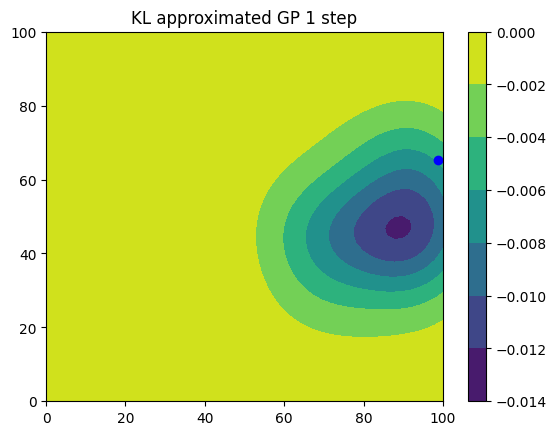

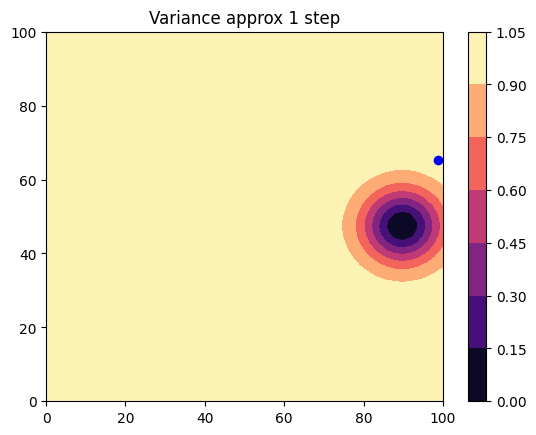

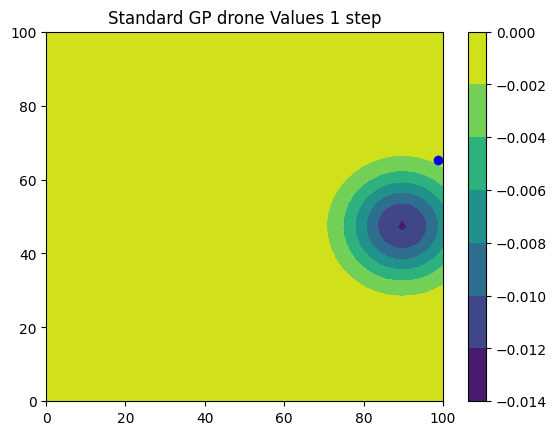

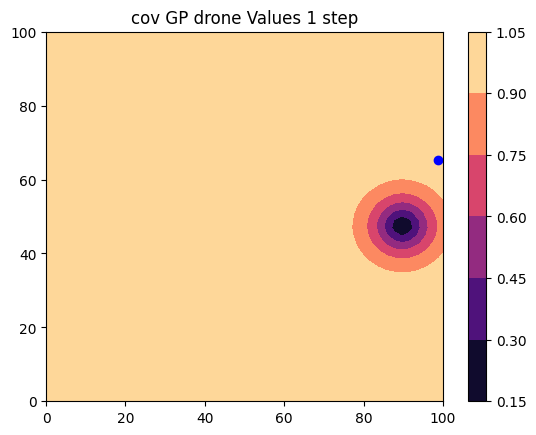

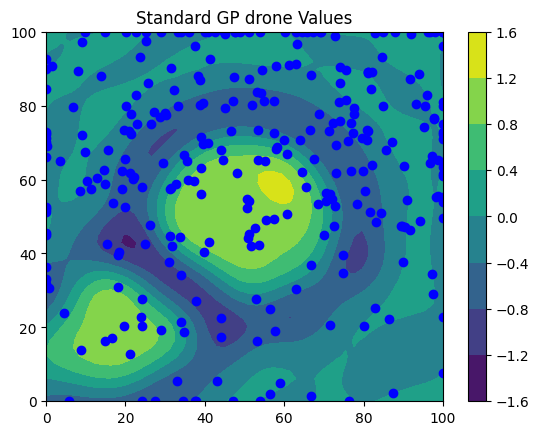

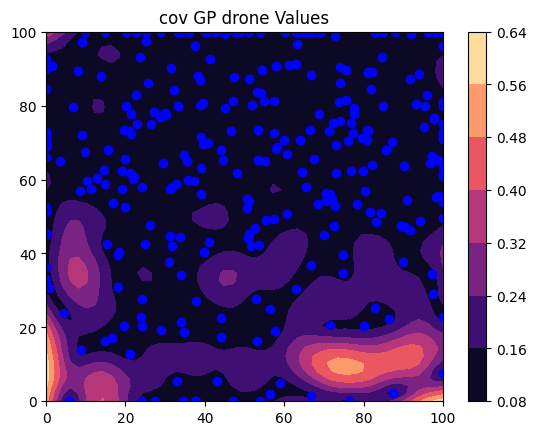

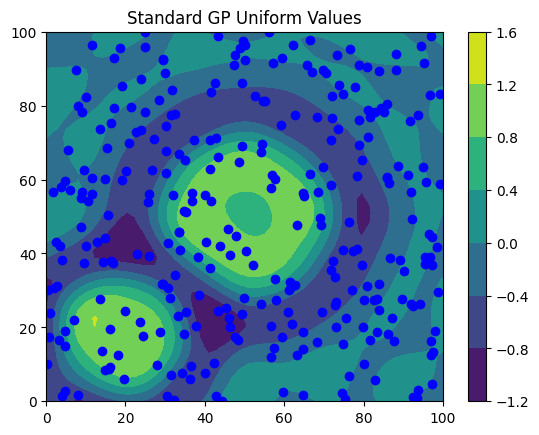

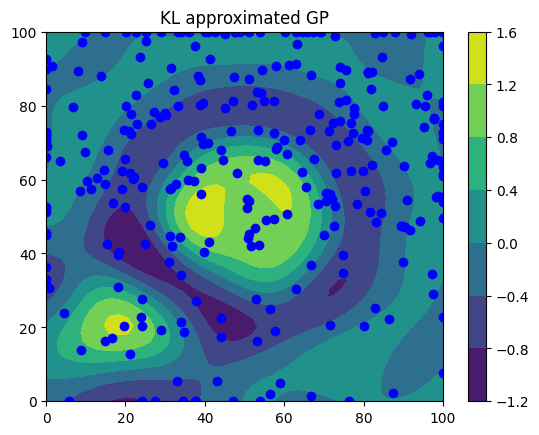

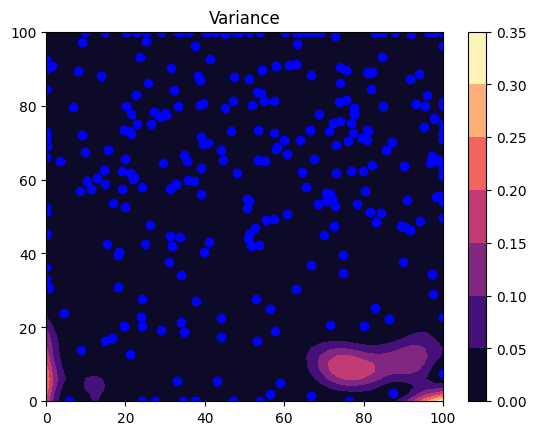

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

length_scale = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel

kernel = RBF(length_scale, length_scale_bounds="fixed") + WhiteKernel(noise_level=sigma_kernel, noise_level_bounds='fixed')
kernel_2 = RBF(length_scale, length_scale_bounds="fixed")

# Initialize drones
print("numero droni ", num_drones)
drones = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = 1, E = E, l = l, sigma= sigma_s, length_scale=length_scale) for i in range(num_drones)]
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Collect data (n_points from a single drone) and learn GP
x = []
y = []
drone = drones[0]
n_points = l
for steps in range(n_points):
  x_new, y_new = drone.collect_data(steps)
  x.append(x_new[0,:].copy())
  y.append(y_new[0])
  drone.move(step_size=20)
  if steps == 0:
    drone.update_gp()

    Z_pred = np.zeros((XY.shape[0],1))
    Z_pred += drone.predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('KL approximated GP 1 step')
    plt.show()

    v_pred = np.zeros((XY.shape[0],1))
    v_pred += drone.variance(XY)
    v_pred = v_pred.reshape(X.shape)

    vmin = v_pred.min()
    vmax = v_pred.max()

    contour = plt.contourf(X, Y, v_pred, cmap='magma', vmin=vmin, vmax=vmax)
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('Variance approx 1 step')
    plt.show()

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Train the model
    gp.fit(np.array(x), np.array(y))

    # Make predictions with the two models and plot for comparison

    # Standard GP
    Z_pred = np.zeros(XY.shape[0])
    Z_pred,  cov_array = gp.predict(XY, return_std=True)
    Z_pred  = Z_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('Standard GP drone Values 1 step')
    plt.show()

    cov_array  = cov_array.reshape(X.shape)
    contour = plt.contourf(X, Y, cov_array, cmap='magma')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('cov GP drone Values 1 step')
    plt.show()
drone.update_gp()

x = np.array(x)
y = np.array(y)

# Create Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the model
gp.fit(x, y)


# Make predictions with the two models and plot for comparison


# Standard GP
Z_pred = np.zeros(XY.shape[0])
Z_pred,  cov_array = gp.predict(XY, return_std=True)
Z_pred  = Z_pred.reshape(X.shape)
contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
for i in range(x.shape[0]):
  plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
plt.colorbar(contour)
plt.title('Standard GP drone Values')
plt.show()

cov_array  = cov_array.reshape(X.shape)
contour = plt.contourf(X, Y, cov_array, cmap='magma')
for i in range(x.shape[0]):
  plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
plt.colorbar(contour)
plt.title('cov GP drone Values')
plt.show()

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)
Z_pred = np.zeros(XY.shape[0])
Z_pred += gp.predict(XY)
Z_pred = Z_pred.reshape(X.shape)
contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
for i in range(X_train.shape[0]):
  plt.scatter(X_train[i, 0], X_train[i, 1], c='blue', label='Drone')
plt.colorbar(contour)
plt.title('Standard GP Uniform Values')
plt.show()

# drone.print_eigenvalues()
# drone.plot_eigenfunctions()

# KL approximated GP
Z_pred = np.zeros((XY.shape[0],1))
Z_pred += drone.predict(XY)
Z_pred = Z_pred.reshape(X.shape)
contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
for i in range(x.shape[0]):
  plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
plt.colorbar(contour)
plt.title('KL approximated GP')
plt.show()

v_pred = np.zeros((XY.shape[0],1))
v_pred += drone.variance(XY)
v_pred = v_pred.reshape(X.shape)

vmin = v_pred.min()
vmax = v_pred.max()

contour = plt.contourf(X, Y, v_pred, cmap='magma', vmin=vmin, vmax=vmax)
for i in range(x.shape[0]):
  plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
plt.colorbar(contour)
plt.title('Variance')
plt.show()


### Matern kernel

The mater kernel for v not equal to 1/2, 3/2, 5/2 does not have a close form for the eigenfunctions. Therefore is not possible to apply the KL approximation.


In [ ]:
# Parameters
m = 1000 # 1000
E = 300  # 100
l = 300 # 1000

X_train = np.random.uniform(size = (l,2)) * area_size
y_train = true_function(X_train)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

length_scale = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel

kernel = Matern(length_scale, nu=1) + WhiteKernel(noise_level=sigma_kernel, noise_level_bounds='fixed')
kernel_2 = Matern(length_scale, nu=1)

# Initialize drones
print("numero droni ", num_drones)
drones = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = 1, E = E, l = l, sigma= sigma_s, length_scale=length_scale) for i in range(num_drones)]
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Collect data (n_points from a single drone) and learn GP
x = []
y = []
drone = drones[0]
n_points = l
for steps in range(n_points):
  x_new, y_new = drone.collect_data()
  x.append(x_new[0,:].copy())
  y.append(y_new[0])
  drone.move(step_size=20)
  if steps == 0:
    drone.update_gp()

    Z_pred = np.zeros((XY.shape[0],1))
    Z_pred += drone.predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('Drone approximated GP 1 step')
    plt.show()

    v_pred = np.zeros((XY.shape[0],1))
    v_pred += drone.variance(XY)
    v_pred = v_pred.reshape(X.shape)

    vmin = v_pred.min()
    vmax = v_pred.max()

    contour = plt.contourf(X, Y, v_pred, cmap='magma', vmin=vmin, vmax=vmax)
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('Drone approx 1 step')
    plt.show()

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Train the model
    gp.fit(np.array(x), np.array(y))

    # Make predictions with the two models and plot for comparison

    # Standard GP
    Z_pred = np.zeros(XY.shape[0])
    Z_pred,  cov_array = gp.predict(XY, return_std=True)
    Z_pred  = Z_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('Standard GP Values 1 step')
    plt.show()

    cov_array  = cov_array.reshape(X.shape)
    contour = plt.contourf(X, Y, cov_array, cmap='magma')
    plt.scatter(drone.position[0], drone.position[1], c='blue', label='Drone')
    plt.colorbar(contour)
    plt.title('cov GP Values 1 step')
    plt.show()
drone.update_gp()

x = np.array(x)
y = np.array(y)

# Create Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Train the model
gp.fit(x, y)


# Make predictions with the two models and plot for comparison

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Standard GP
Z_pred = np.zeros(XY.shape[0])
Z_pred,  cov_array = gp.predict(XY, return_std=True)
Z_pred  = Z_pred.reshape(X.shape)
contour = axs[0].contourf(X, Y, Z_pred, cmap='viridis')
# for i in range(x.shape[0]):
#   plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
fig.colorbar(contour, ax=axs[0])
axs[0].set_title('Standard GP mean')
# plt.show()

cov_array  = cov_array.reshape(X.shape)
contour = axs[1].contourf(X, Y, cov_array, cmap='magma')
# for i in range(x.shape[0]):
#   axs[1].scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
fig.colorbar(contour, ax=axs[1])
axs[1].set_title('standard GP variance')
# plt.show()

# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# gp.fit(X_train, y_train)
# Z_pred = np.zeros(XY.shape[0])
# Z_pred += gp.predict(XY)
# Z_pred = Z_pred.reshape(X.shape)
# contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
# for i in range(X_train.shape[0]):
#   plt.scatter(X_train[i, 0], X_train[i, 1], c='blue', label='Drone')
# plt.colorbar(contour)
# plt.title('Standard GP Uniform Values')
# plt.show()

# drone.print_eigenvalues()
# drone.plot_eigenfunctions()

# KL approximated GP
Z_pred = np.zeros((XY.shape[0],1))
Z_pred += drone.predict(XY)
Z_pred = Z_pred.reshape(X.shape)
contour = axs[2].contourf(X, Y, Z_pred, cmap='viridis')
fig.colorbar(contour, ax=axs[2])
# for i in range(x.shape[0]):
#   plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
axs[2].set_title('Drone approximated mean')
# plt.show()

v_pred = np.zeros((XY.shape[0],1))
v_pred += drone.variance(XY)
v_pred = v_pred.reshape(X.shape)

vmin = v_pred.min()
vmax = v_pred.max()

contour = axs[3].contourf(X, Y, v_pred, cmap='magma', vmin=vmin, vmax=vmax)
# for i in range(x.shape[0]):
#   plt.scatter(x[i, 0], x[i, 1], c='blue', label='Drone')
fig.colorbar(contour, ax=axs[3])
axs[3].set_title('Drone approximated Variance')
plt.show()


## Test 2: confronto GP_E con GP_E distribuito: ✅

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import scipy

length_scale = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel
seed = 0

kernel = RBF(length_scale, length_scale_bounds="fixed") + WhiteKernel(noise_level=sigma_kernel, noise_level_bounds='fixed')
kernel_2 = RBF(length_scale, length_scale_bounds="fixed")

print("numero droni ", num_drones)
drones = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = num_drones, E = E, l = l, sigma= sigma_s, length_scale=length_scale, seed = 0) for i in range(num_drones)]
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

def build_matrix(drones):
  gamma = 0.4  # consensus rate
  max_distance = 60
  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones) * ((1- gamma))
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  num_neighbors = np.sum(adjacency_matrix, axis=1)
  # Avoid division by zero by setting num_neighbors to 1 where it is zero
  num_neighbors[num_neighbors == 0] = 1
  normalized_matrix = adjacency_matrix / num_neighbors[:, np.newaxis] * gamma
  matrix = matrix + normalized_matrix
  return matrix


numero droni  16
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11


numero droni  16
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
alpha average  [[ 1.08484152e+00  6.88426414e-02  7.04979615e-02 ... -4.01466438e-10
  -4.57791616e-10  1.85143567e-10]
 [ 6.88426414e-02  7.60983739e-01 -1.47391084e-02 ... -9.17879778e-11
  -3.32169332e-10  1.34145480e-10]
 [ 7.04979615e-02 -1.47391084e-02  8.94273368e-01 ...  4.44511598e-10
   5.80707263e-12  2.86607113e-10]
 ...
 [-4.014

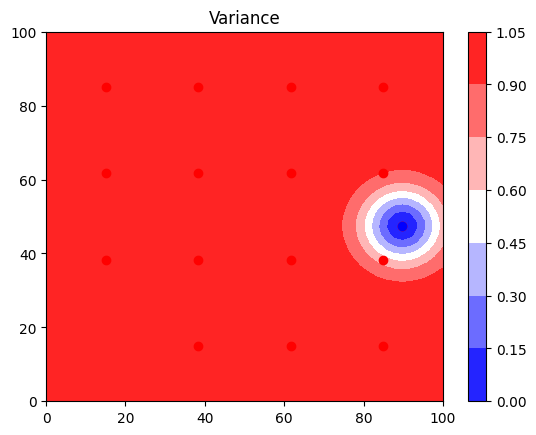

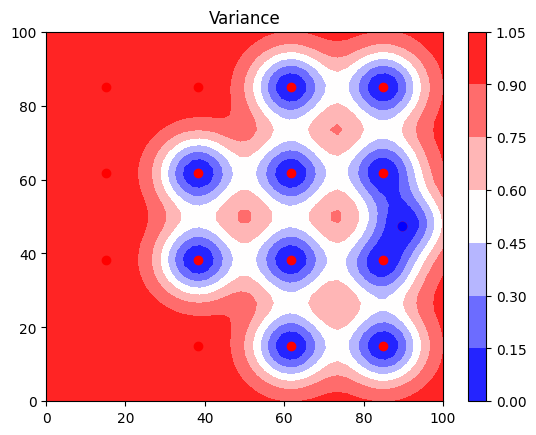

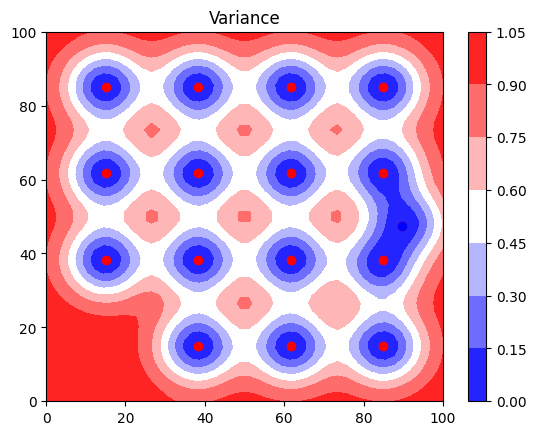

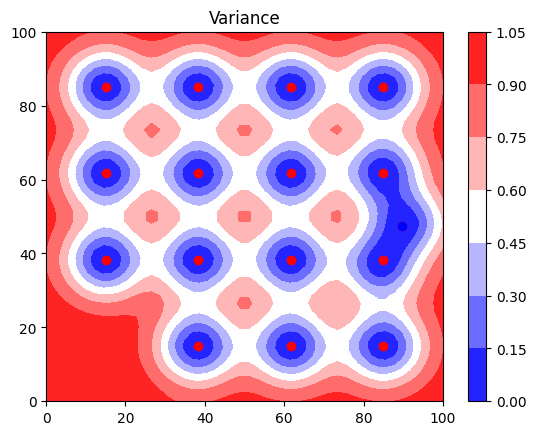

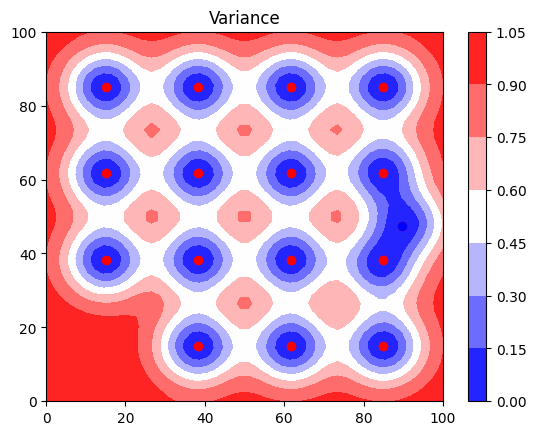

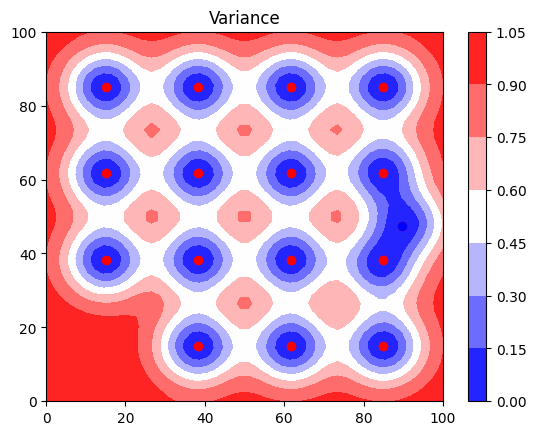

consensus after step  42
alpha equal  False
------
beta equal  False


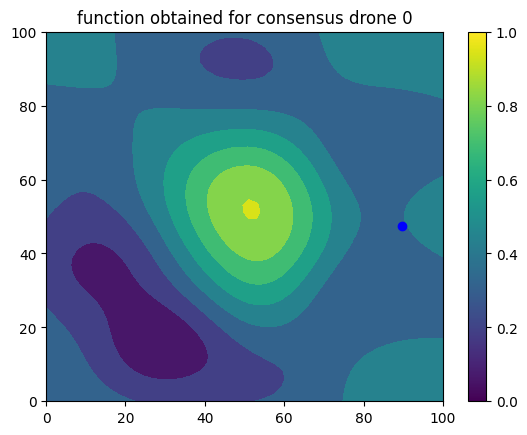

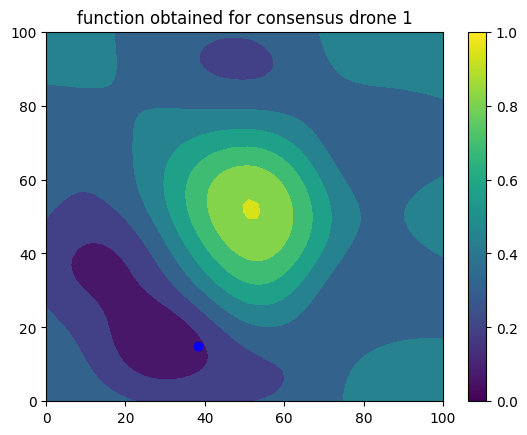

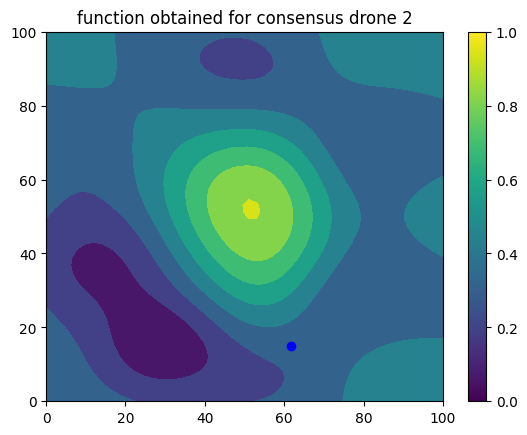

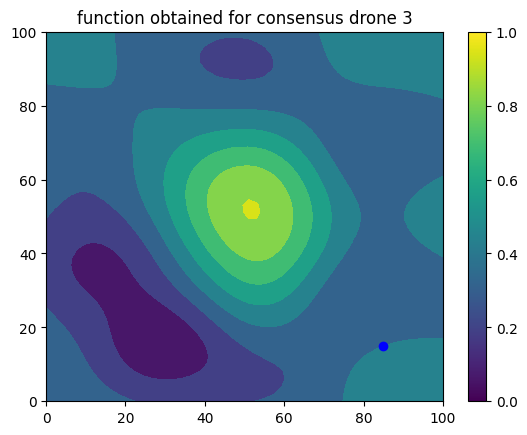

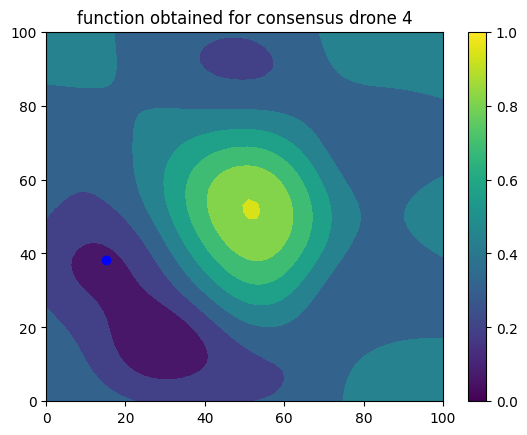

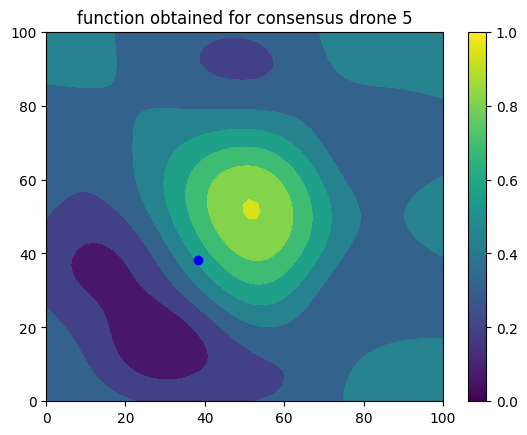

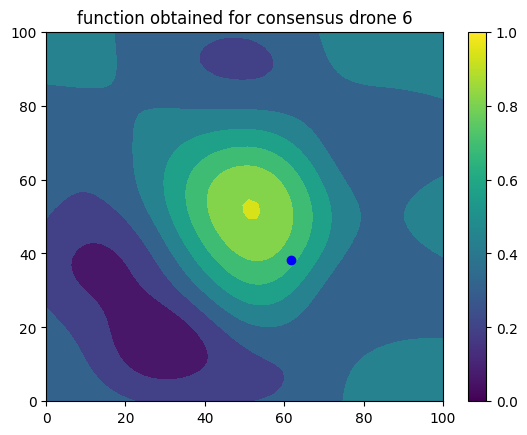

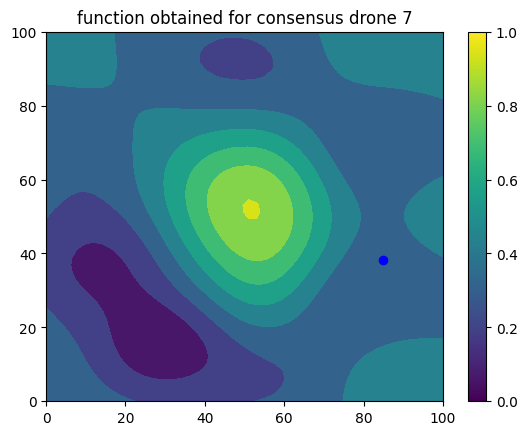

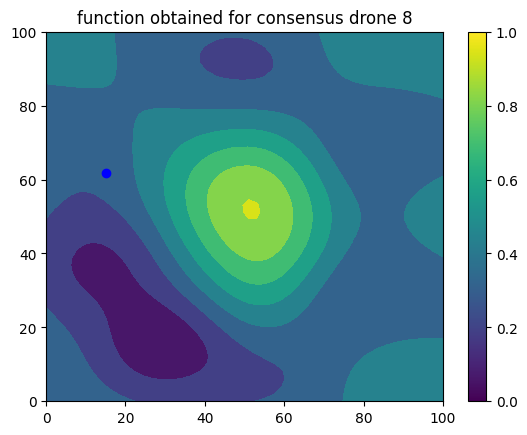

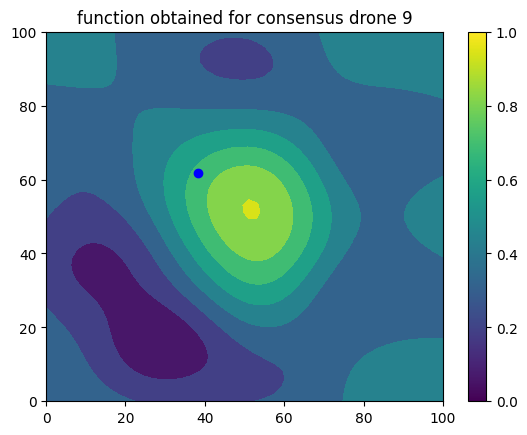

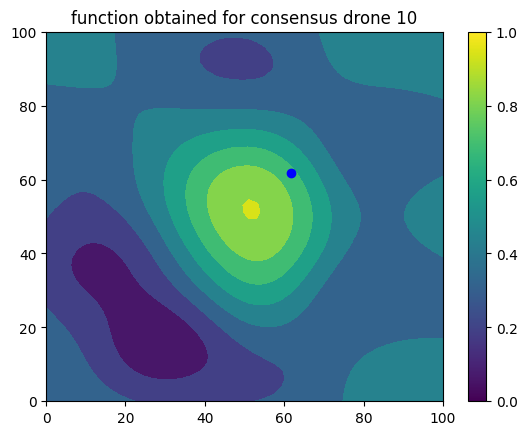

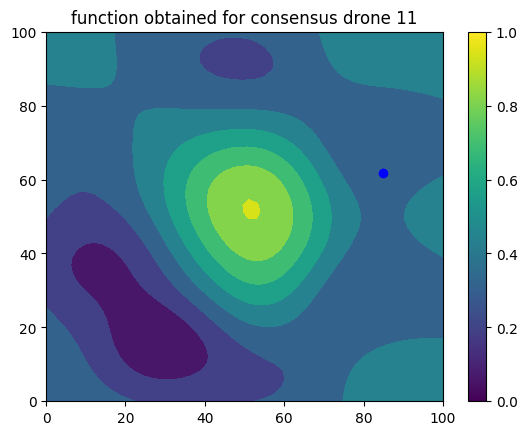

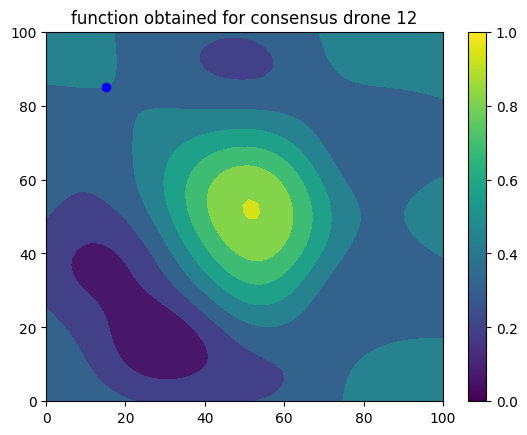

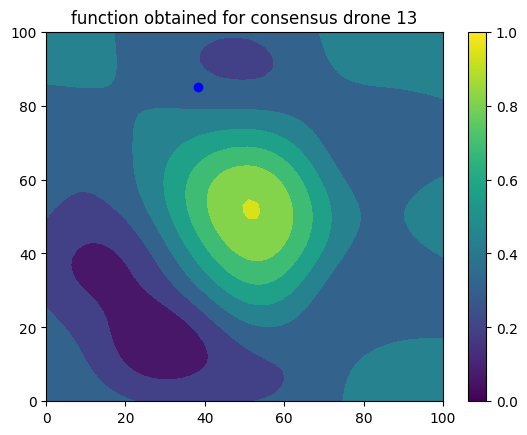

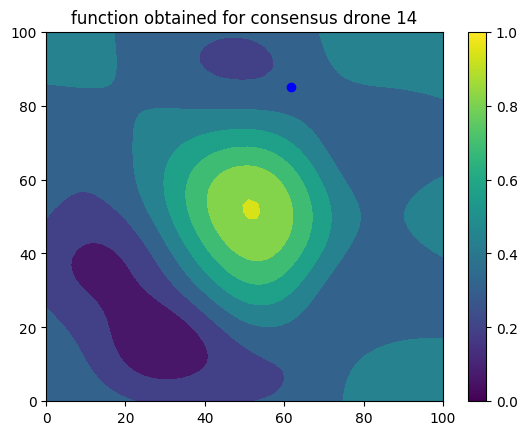

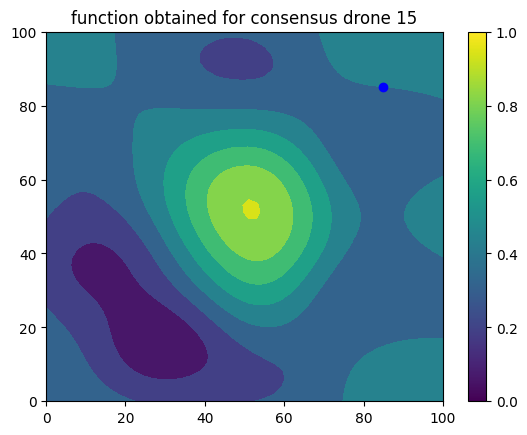

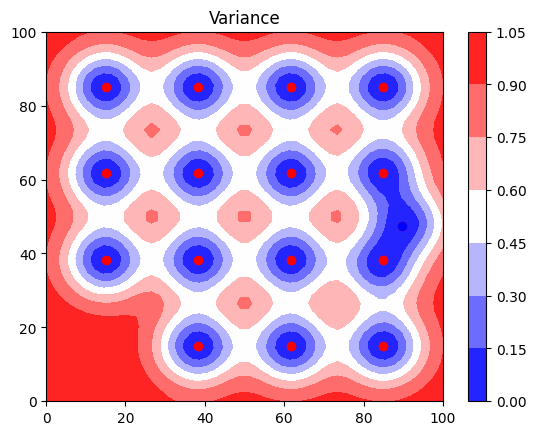

alpha equal  True
------
beta equal  True


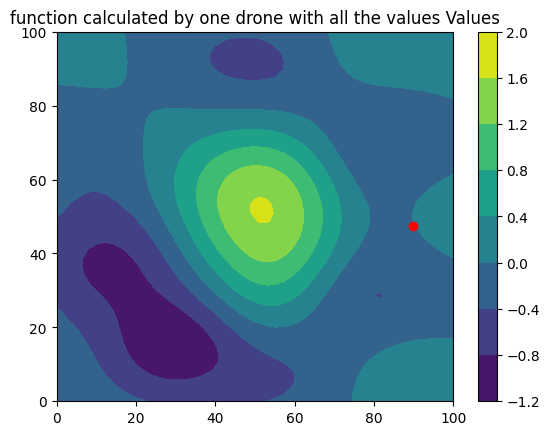

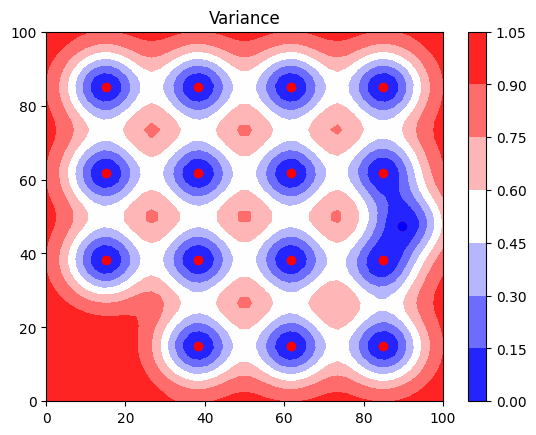

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import scipy

length_scale = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel
seed = 0

kernel = RBF(length_scale, length_scale_bounds="fixed") + WhiteKernel(noise_level=sigma_kernel, noise_level_bounds='fixed')
kernel_2 = RBF(length_scale, length_scale_bounds="fixed")

print("numero droni ", num_drones)
drones = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = num_drones, E = E, l = l, sigma= sigma_s, length_scale=length_scale, seed = 0) for i in range(num_drones)]
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

def build_matrix(drones):
  gamma = 0.4  # consensus rate
  max_distance = 60

  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones) * ((1- gamma))
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  num_neighbors = np.sum(adjacency_matrix, axis=1)
  # Avoid division by zero by setting num_neighbors to 1 where it is zero
  num_neighbors[num_neighbors == 0] = 1
  normalized_matrix = adjacency_matrix / num_neighbors[:, np.newaxis] * gamma
  matrix = matrix + normalized_matrix
  return matrix
# #BUILD adjacency matrix:
adjacency = build_matrix(drones)

print_Eig = False #bool to print eigenvalues and eigenvectors
if print_Eig:
  print("adjacency")
  print(adjacency)
  print("eigenvalues = ", )
  print("left eigenvector")
  print(scipy.linalg.eig(adjacency, left=True))

x_tr = [] #array use to plot all the data collected

def consensus_f(drones, num_drones):
  consensus = False
  step = 0
  alphas = np.zeros((num_drones, E*E))
  bhetas = np.zeros((num_drones, E))
  while (not consensus):
    for i in range(num_drones):
      alphas[i,:] = drones[i].alpha.flatten()
      # print("compressed alpha ", alphas)
      bhetas[i,:] = drones[i].beta.flatten()

    alphas_old = alphas.copy()
    bhetas_old = bhetas.copy()

    alphas = adjacency @ alphas
    bhetas = adjacency @ bhetas
    for i in range(num_drones):
      drones[i].alpha = alphas[i,:].reshape((E,E))
      # print("drone alpha ", drones[1].alpha)
      drones[i].beta = bhetas[i,:].reshape((E,1))

    if step % 10 == 0:
      v_pred = np.zeros((XY.shape[0],1))
      v_pred += drones[0].variance(XY)
      v_pred = v_pred.reshape(X.shape)
      contour = plt.contourf(X, Y, v_pred, cmap='bwr')
      plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
      plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
      plt.colorbar(contour)
      plt.title('Variance')
      plt.show()

    if np.linalg.norm(alphas - alphas_old) < 1e-5:
      if  np.linalg.norm(bhetas - bhetas_old) < 1e-5:
        consensus = True
        print("consensus after step ", step)
    step +=1

for i, drone in enumerate(drones):
  X_new, y_new = drone.collect_data(i)
  x_tr.append(X_new[0,:].copy())
# for step in range(600):
#   #CASE distributed moving
#   # Simulate the drones collecting data and updating the GP
#   if step == 0:
#     for drone in drones:
#         X_new, y_new = drone.collect_data()
#         x_tr.append(X_new[0,:].copy())
#         # drone.update_gp()
#         drone.move(5)
#   elif step % 2 == 0:
#     for drone in drones:
#         X_new, y_new = drone.collect_data()
#         x_tr.append(X_new[0,:].copy())
#         # drone.moving_update(X_new, y_new)
#         drone.move(5)
#     # if step % 50 == 0:
#     #   consensus_f(drones, num_drones)
#   else:
#     for drone in drones:
#         drone.move(5)

#Comparison with the real average ------------
bheta_average = np.zeros((E,1))
alpha_average = np.zeros((E,E))

for drone in drones:
  drone.update_gp()
  bheta_average += drone.beta
  alpha_average += drone.alpha

bheta_average = bheta_average/num_drones
alpha_average = alpha_average/num_drones
print("alpha average ", alpha_average)
adjacency = build_matrix(drones)
print("adjacency")
print(adjacency)
v_pred = np.zeros((XY.shape[0],1))
v_pred += drones[0].variance(XY)
v_pred = v_pred.reshape(X.shape)
contour = plt.contourf(X, Y, v_pred, cmap='bwr')
plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()
consensus_f(drones, num_drones)
print("alpha equal ", np.linalg.norm(alpha_average - drones[0].alpha) < 1e-5)
print("------")
print("beta equal ", np.linalg.norm(bheta_average - drones[0].beta) < 1e-5)
#---------------------------------------------

for i, drone in enumerate(drones):
  Z_pred = np.zeros((XY.shape[0],1))
  Z_pred += drone.predict(XY)
  Z_pred = Z_pred.reshape(X.shape)

  # Visualize the positions
  plt.contourf(X, Y, Z_pred, cmap='viridis')
  plt.scatter(drone_positions[i, 0], drone_positions[i, 1], c='blue', label='Drone 0')
  plt.colorbar()
  plt.title(f'function obtained for consensus drone {i}')
  plt.show()


v_pred = np.zeros((XY.shape[0],1))
v_pred += drones[0].variance(XY)
v_pred = v_pred.reshape(X.shape)
contour = plt.contourf(X, Y, v_pred, cmap='bwr')
plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()

#Comparison with the Approximated GP with all the data in one drone -----------
for i in range(num_drones):
  if i == 0:
    drone0 = drones[0]
  else:
    drone0.X_train += drones[i].X_train
    drone0.y_train += drones[i].y_train

drone0.num_drones = 1
drone0.update_gp()
print("alpha equal ", np.linalg.norm(alpha_average - drone0.alpha) < 1e-5)
print("------")
print("beta equal ", np.linalg.norm(bheta_average - drone0.beta) < 1e-5)

x_tr = np.array(x_tr)

Z_pred = np.zeros((XY.shape[0],1))
Z_pred += drone0.predict(XY)
Z_pred = Z_pred.reshape(X.shape)
# Visualize the positions
contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
plot_data_collected = False
if plot_data_collected:
  plt.scatter(x_tr[:,0], x_tr[:,1], c='blue', label='Drones')
plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='red', label='Drone 0')
plt.colorbar(contour)
plt.title('function calculated by one drone with all the values Values')
plt.show()

v_pred = np.zeros((XY.shape[0],1))
v_pred += drone0.variance(XY)
v_pred = v_pred.reshape(X.shape)
contour = plt.contourf(X, Y, v_pred, cmap='bwr')
plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()


# Kalman Drones

This class defines the drone using the Distributed GP via KF

In [ ]:
import time
class Kalman_drone:
    def __init__(self, position, area_size, kernel, E, seed = 0):
        self.position = position
        self.area_size = area_size
        self.kernel = kernel
        self.X_train = []
        self.y_train = []
        self.E = E
        self.map_f = wind_field_2d
        self.clouds = clouds_2d

        #Kalman filter parameters:
        self.theta = np.zeros((E,1))
        self.P = 1 * np.eye(E)
        self.sigma_w = 0.005
        self.Q = self.sigma_w * np.eye(E)
        self.sigma_s = 5

        np.random.seed(seed)
        #Nystrom Method
        self.points = np.random.rand(E, 2) * area_size

        # Compute the kernel matrix
        kernel_matrix = self.kernel(self.points, self.points)

        # Perform Singular Value Decomposition (SVD)
        U, S, Vt = np.linalg.svd(kernel_matrix)

        # Create the diagonal matrix of singular values
        Lambda_E = np.diag(S)
        self.U = U
        self.Lambda_E = Lambda_E

    def move(self, step_size=1.0):
        #perform a random walk in space
        iterate = True
        # while iterate:
        angle = np.random.uniform(0, 2 * np.pi)
        high = np.random.uniform(-1, 1)
        old_pos = [self.position[0], self.position[1]]
        self.position[0] += step_size * np.cos(angle)
        self.position[1] += step_size * np.sin(angle)
        # self.position[2] += step_size * high
        self.position[0] = np.clip(self.position[0], 0, self.area_size)
        self.position[1] = np.clip(self.position[1], 0, self.area_size)
        # self.position[2] = np.clip(self.position[1], 0, self.area_size)

    def kalman_update(self, x, y):
      x_hat = self.theta
      P_hat = self.P + self.Q # In this case the parameter vector is a random walk with gaussian step, where step variables are independent of each other
      # print(f"shape X: {x[0][0]}")
      # print(f"shape H: {(self.kernel(np.array([[x[0][0], y[0]]]), self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))).shape}")
      H = self.kernel(np.array([[x[0][0], x[0][1]]]), self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      # R = sigma_s**2
      R = sigma_s**2 * np.eye(H.shape[0])
      K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + R)
      self.theta = x_hat + K @ (y[0] - H @ x_hat)
      self.P = (np.eye(len(self.theta)) - K @ H) @ P_hat

    def collect_data(self, t):
        X_new = self.position.reshape(1, -1).copy()
        y_new = self.map_f(X_new, self.clouds, t, wind_direction_clouds)
        self.X_train.append(X_new)
        self.y_train.append(y_new)
        return X_new, y_new

    def predict(self, X):
      #Predict as it was a Weighted Linear Regression
      #Calculate the mean the system:
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      mu = phi @ self.theta
      return mu

    def variance(self, X):
      phi = self.kernel(X, self.points) @ self.U @ np.linalg.inv(np.sqrt(self.Lambda_E))
      sigma_squared = phi @ self.P @ phi.T
      return np.diag(sigma_squared)



## Kalman_drone_test

## Distributed Kalman Drones 1

Coefficient in the Averaging method

numero droni  16
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
adjacency  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

<ipython-input-20-1176f1781a66>:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')


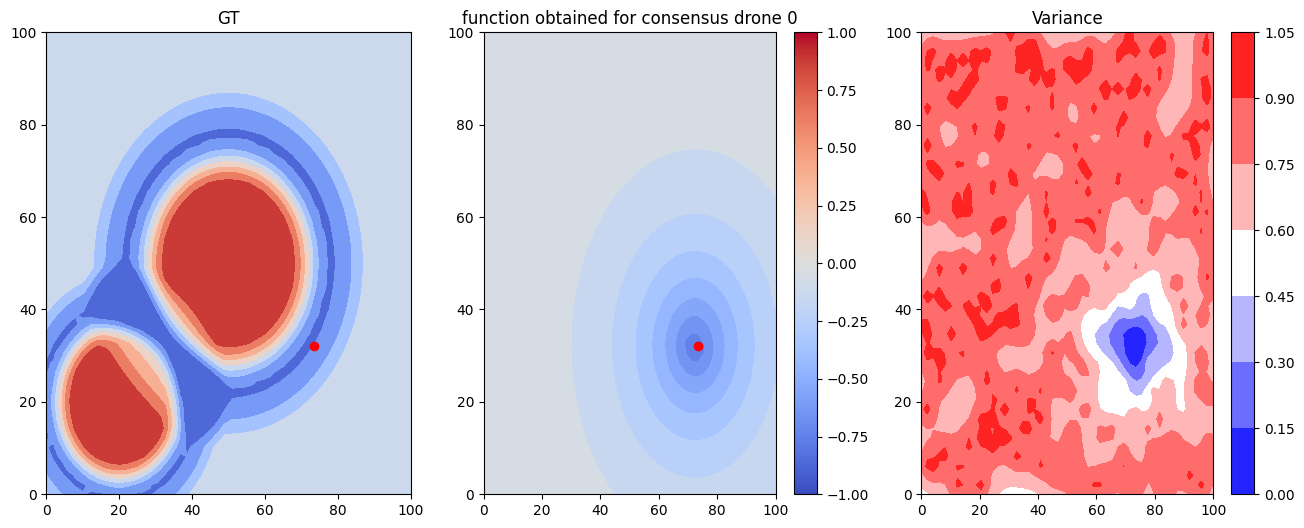

Kalman update
step 50


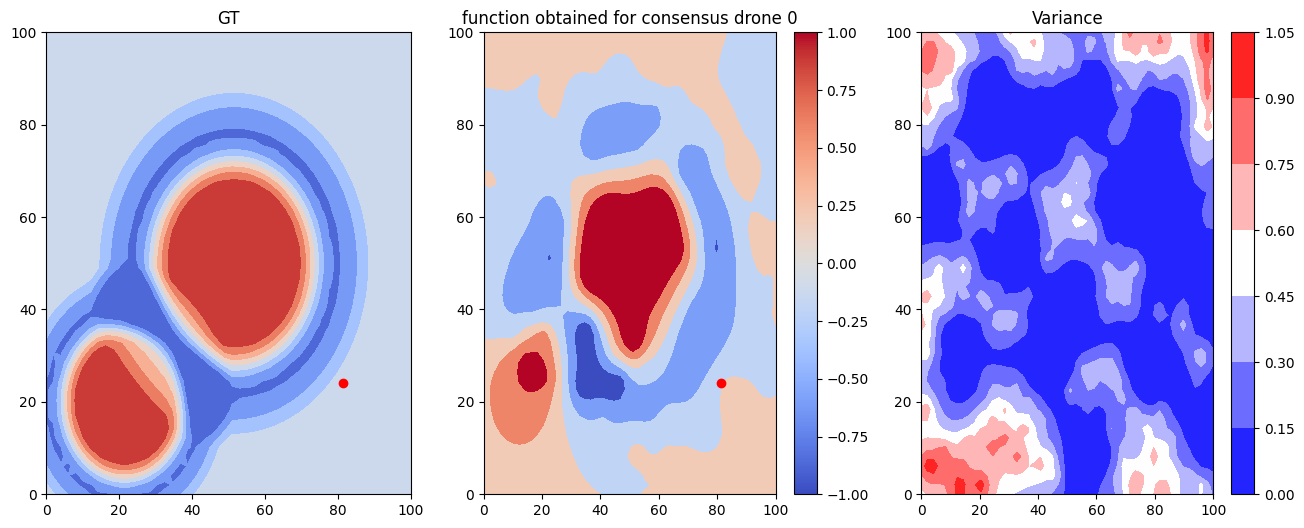

Kalman update
step 100


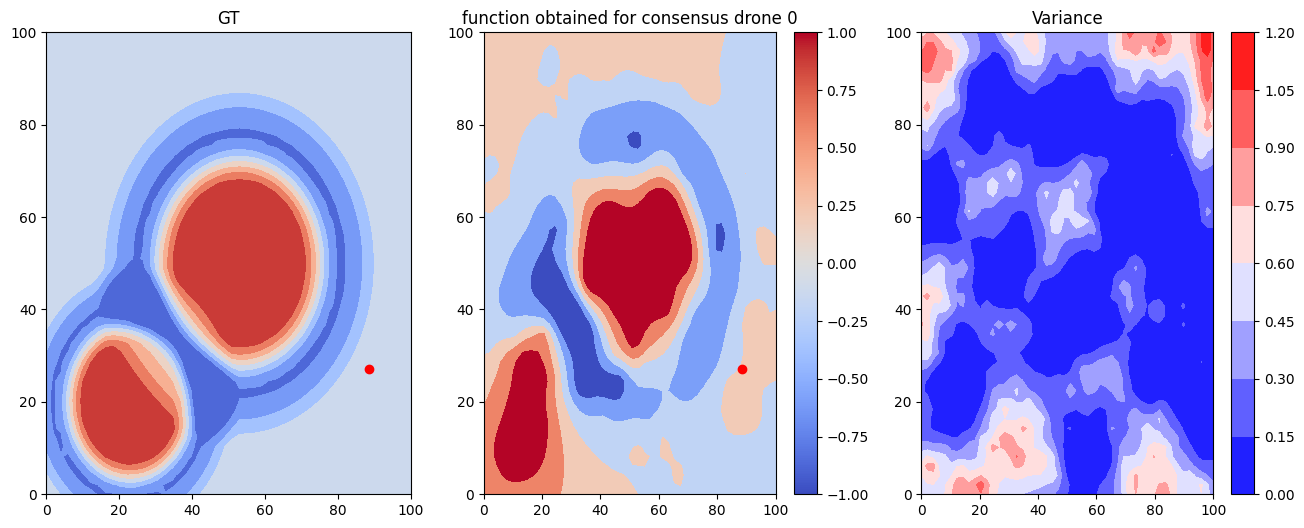

Kalman update
step 150


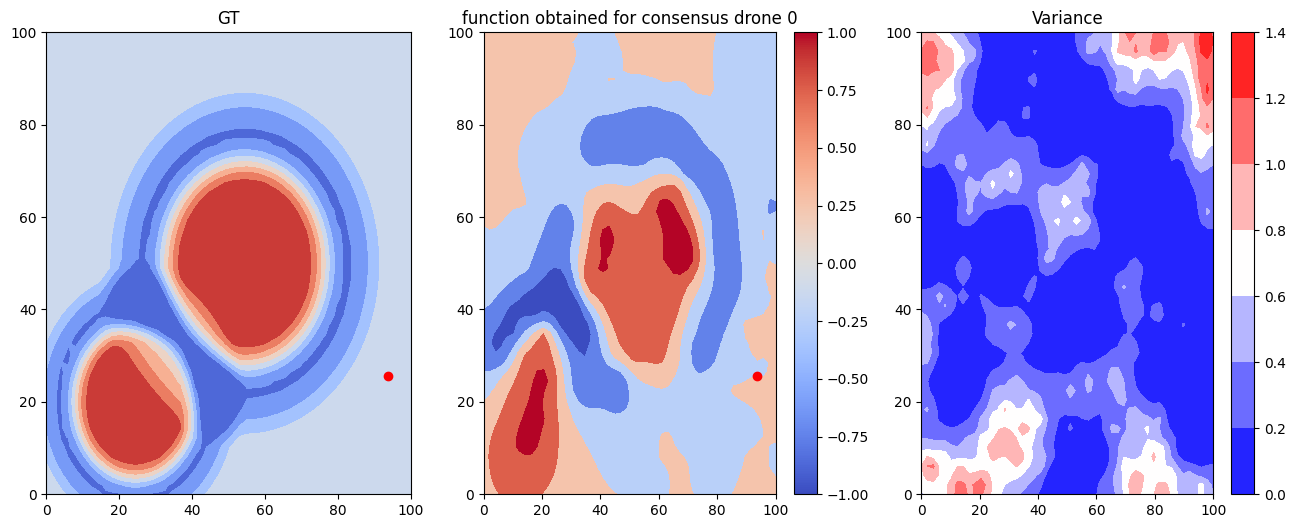

Kalman update
step 200


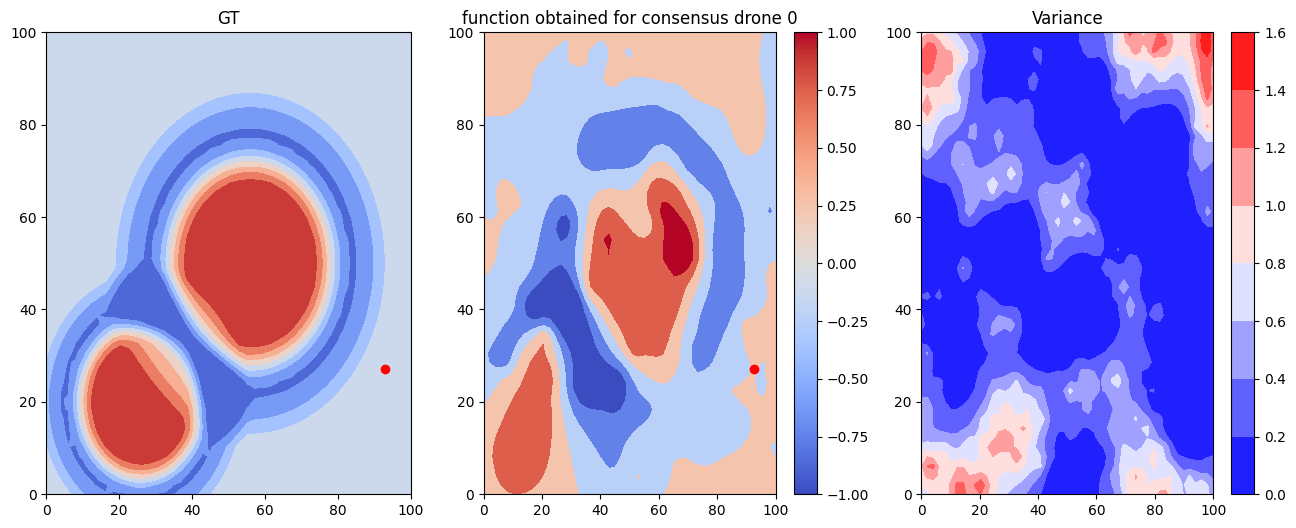

Kalman update
step 250


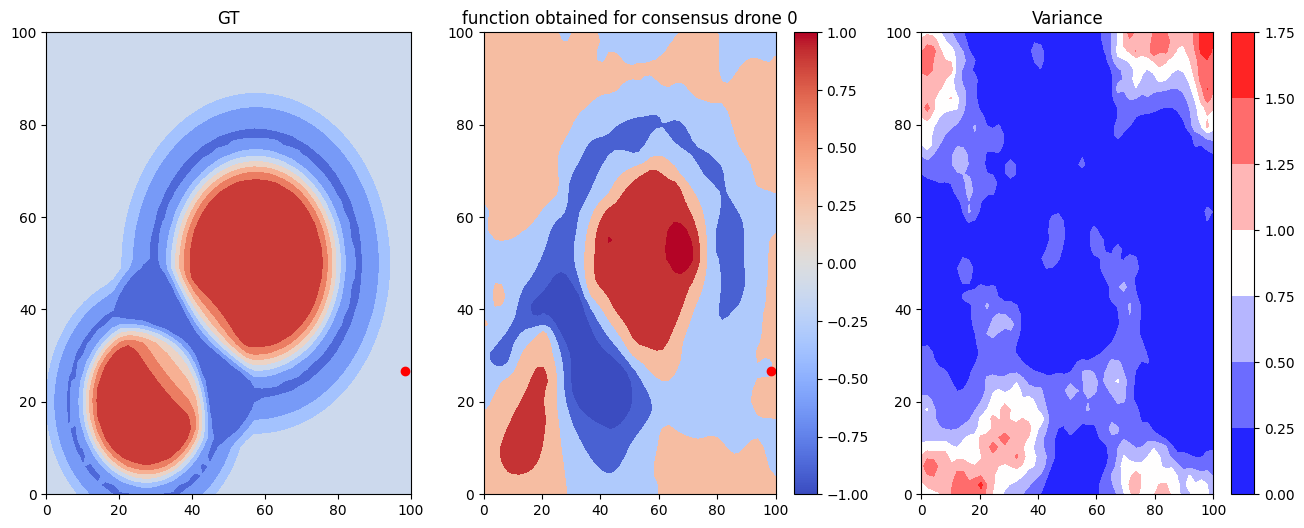

Kalman update
step 300


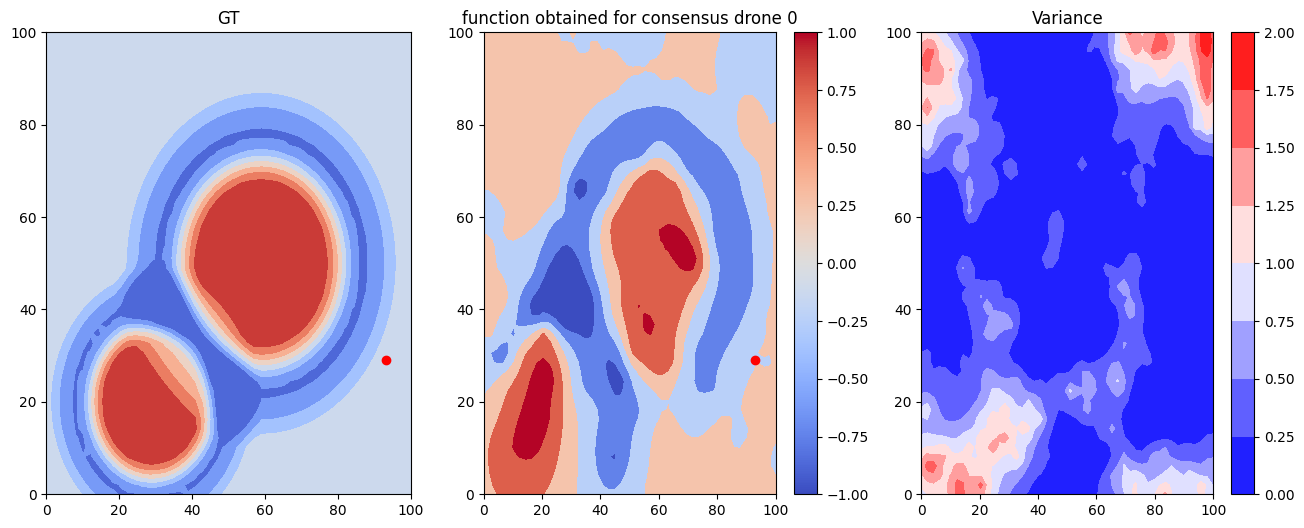

Kalman update
step 350


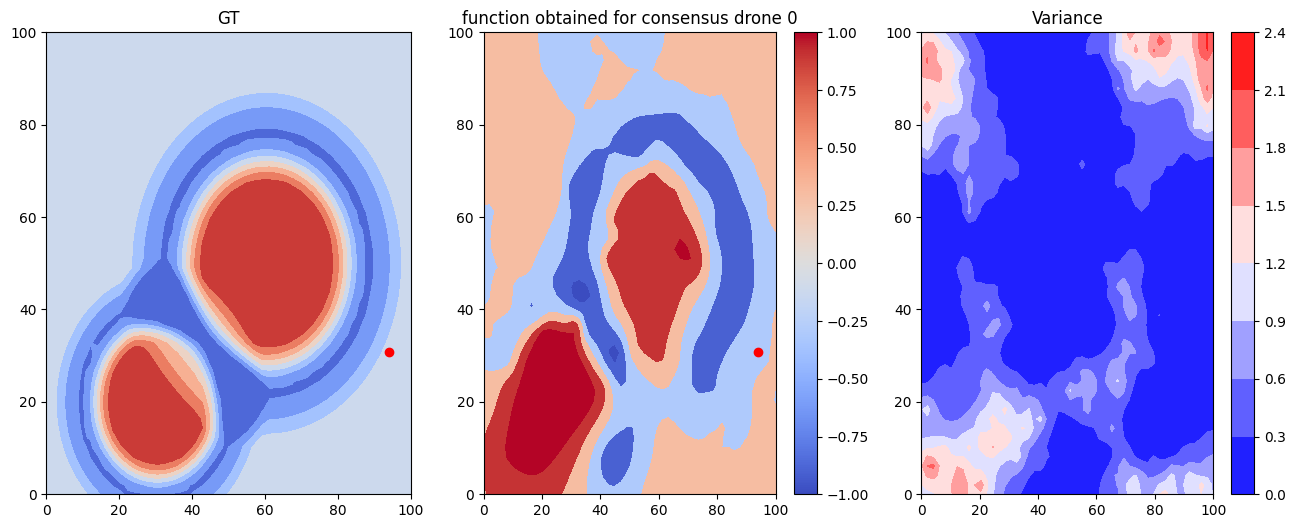

Kalman update
step 400


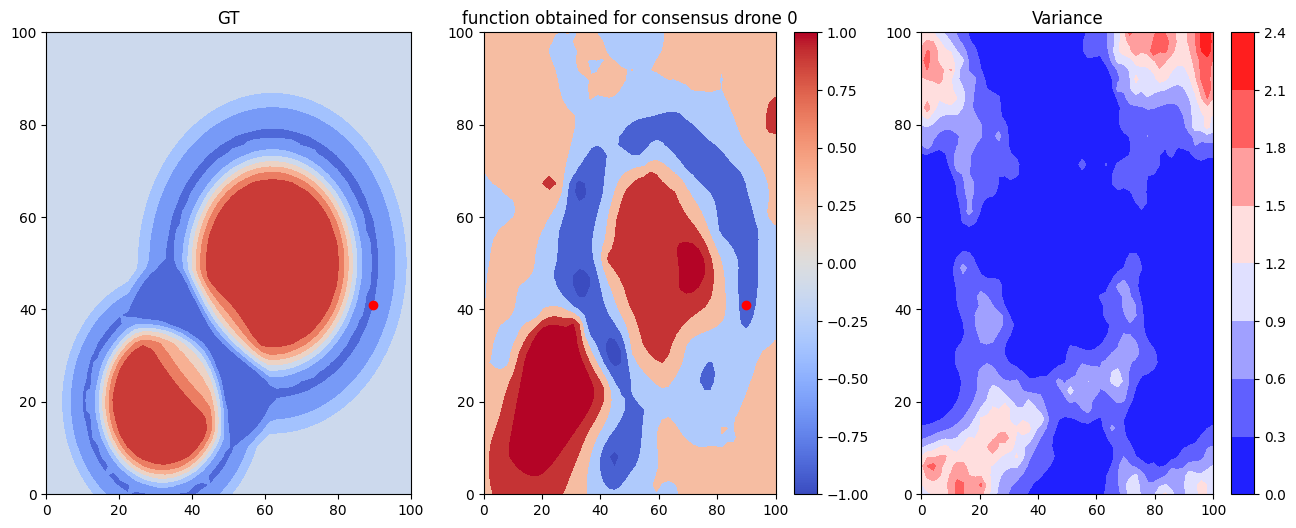

Kalman update
step 450


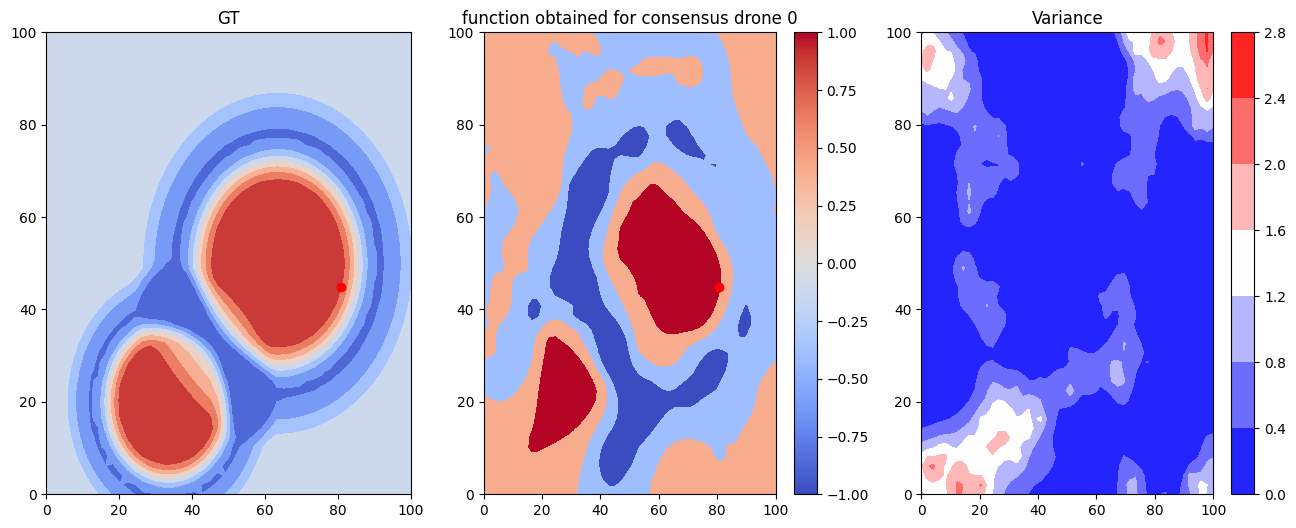

Kalman update
step 500


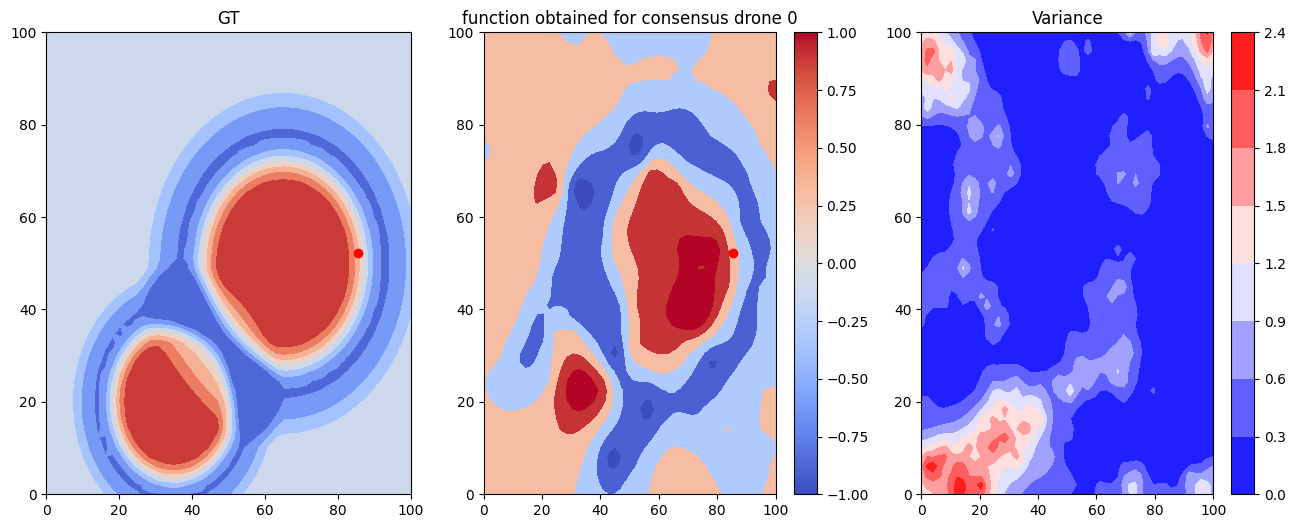

Kalman update
step 550


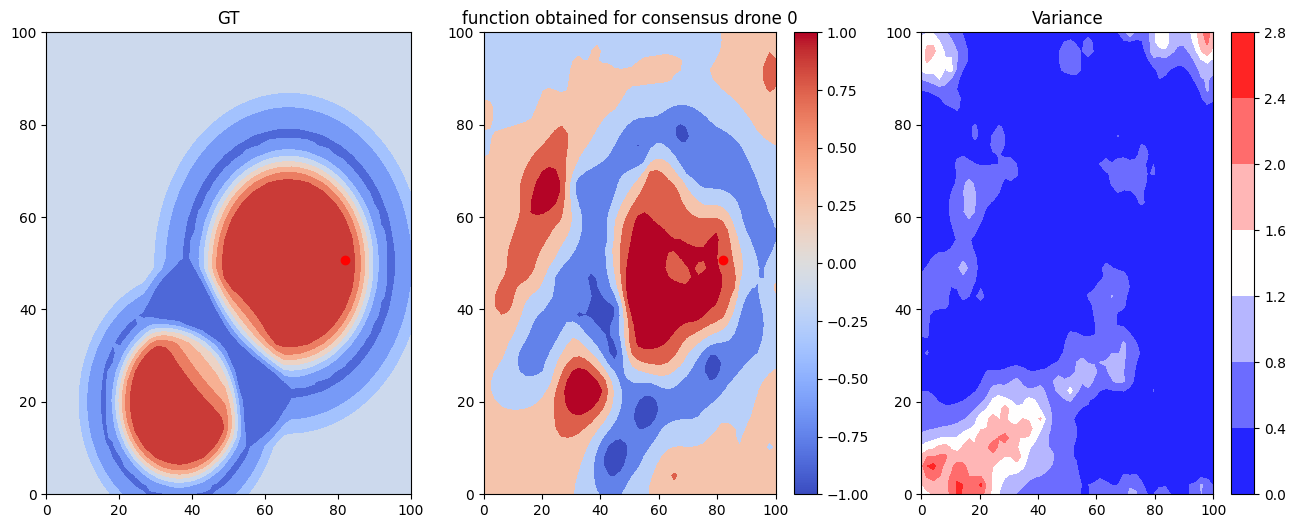

Kalman update
step 600


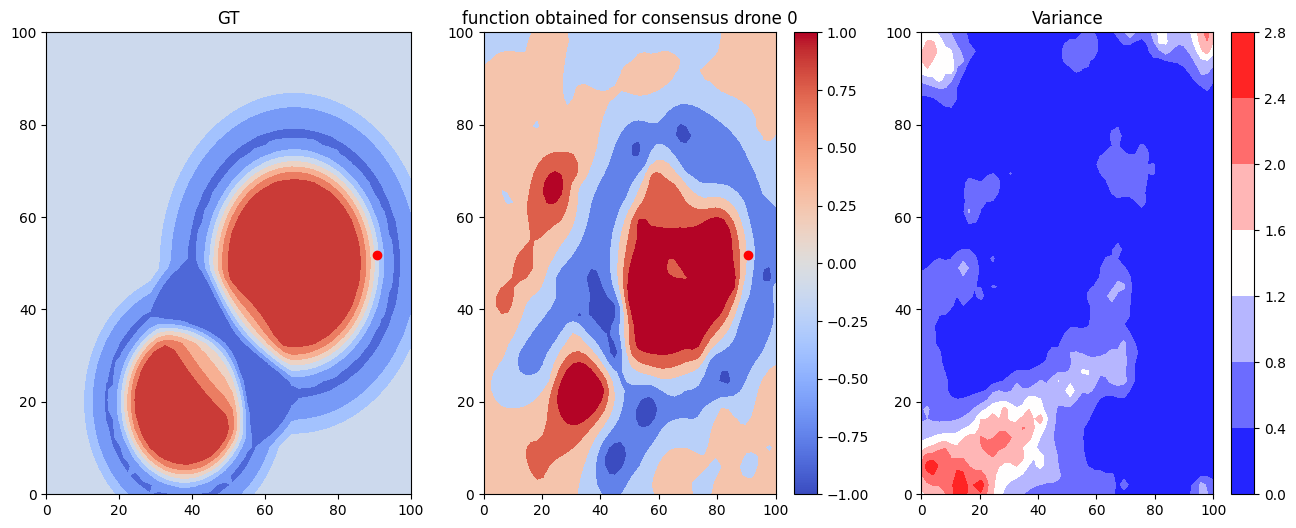

step


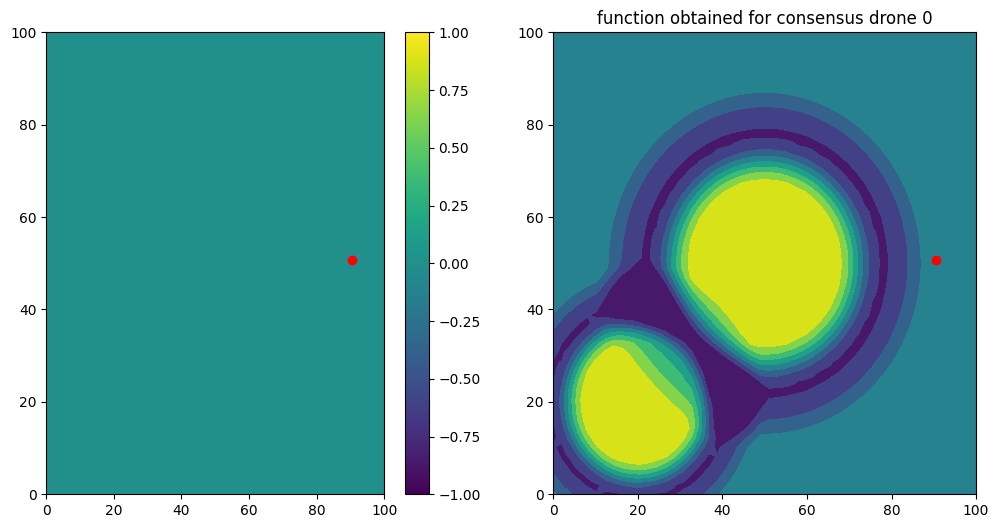

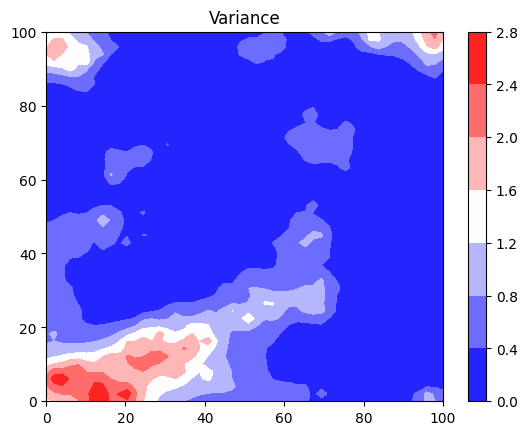

step


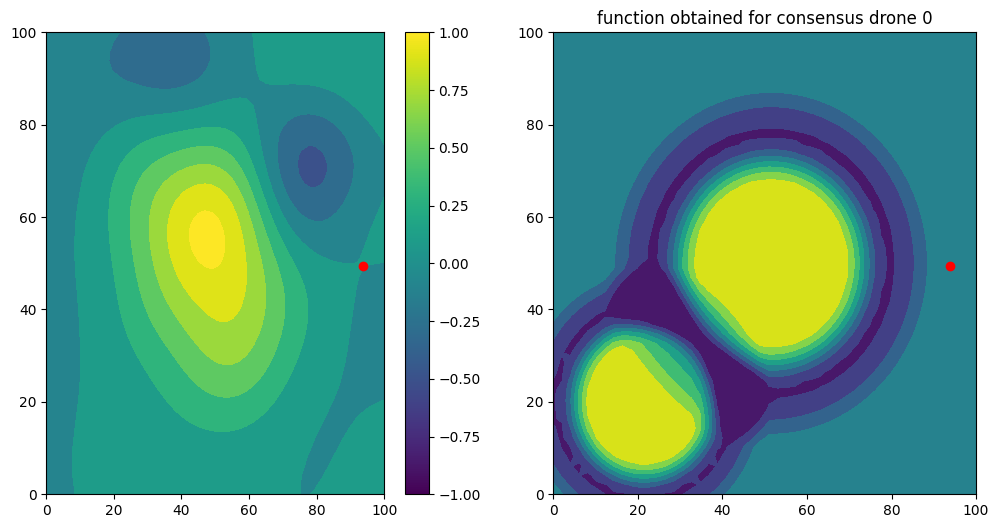

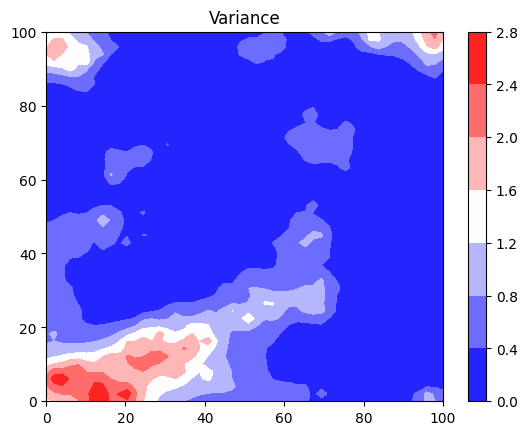

step


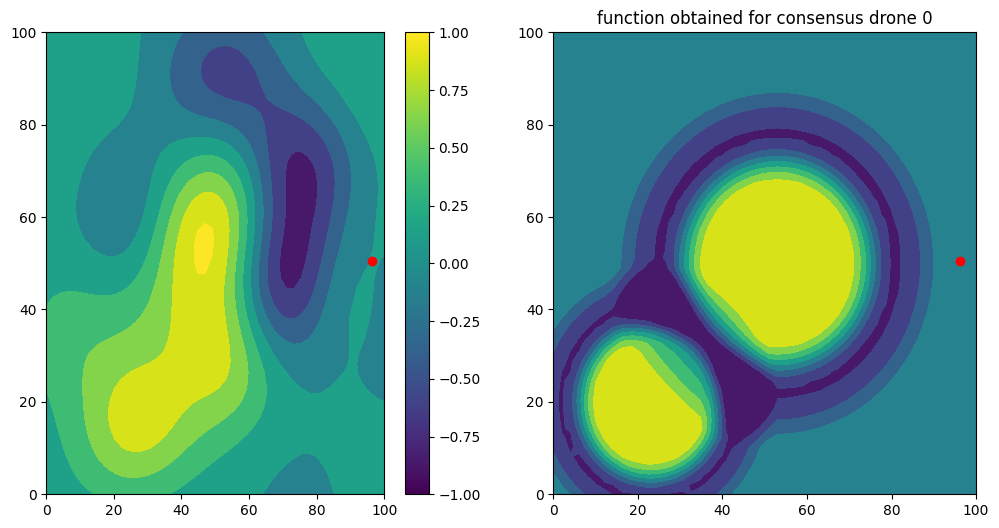

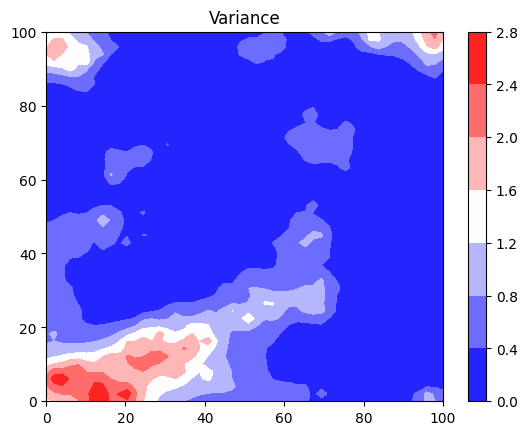

step


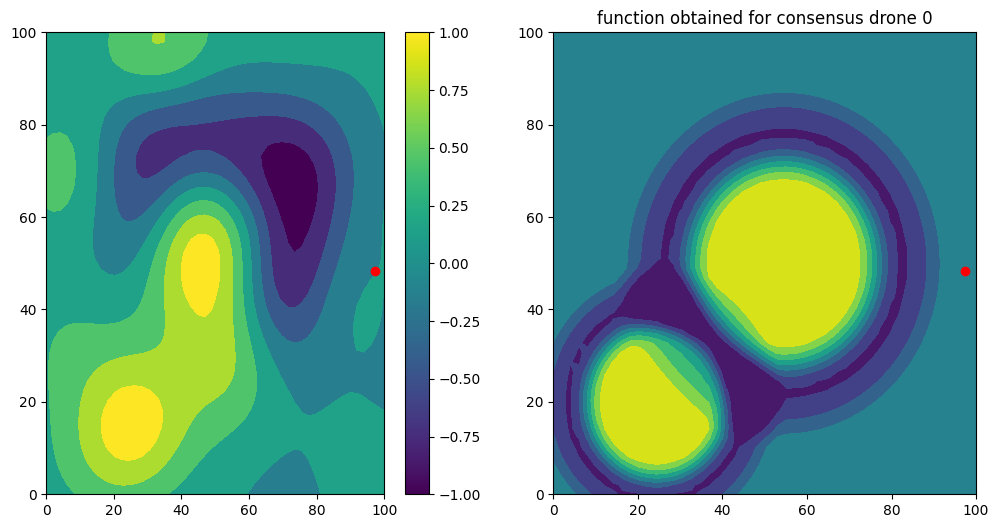

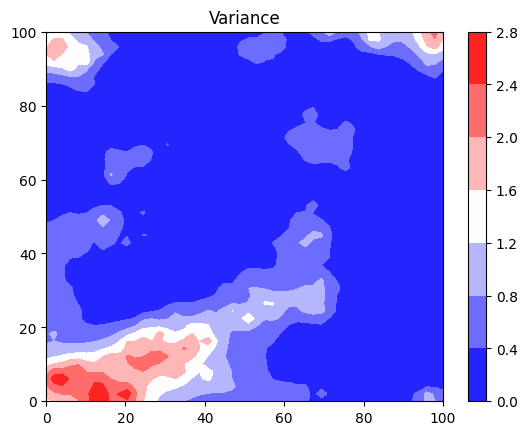

step


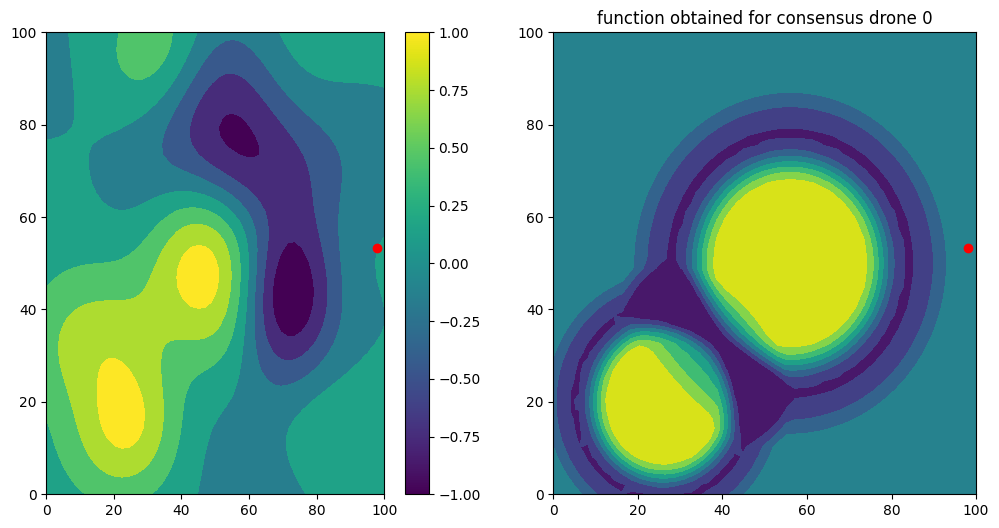

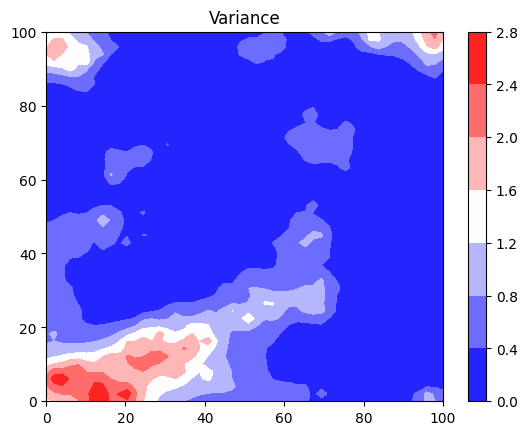

step


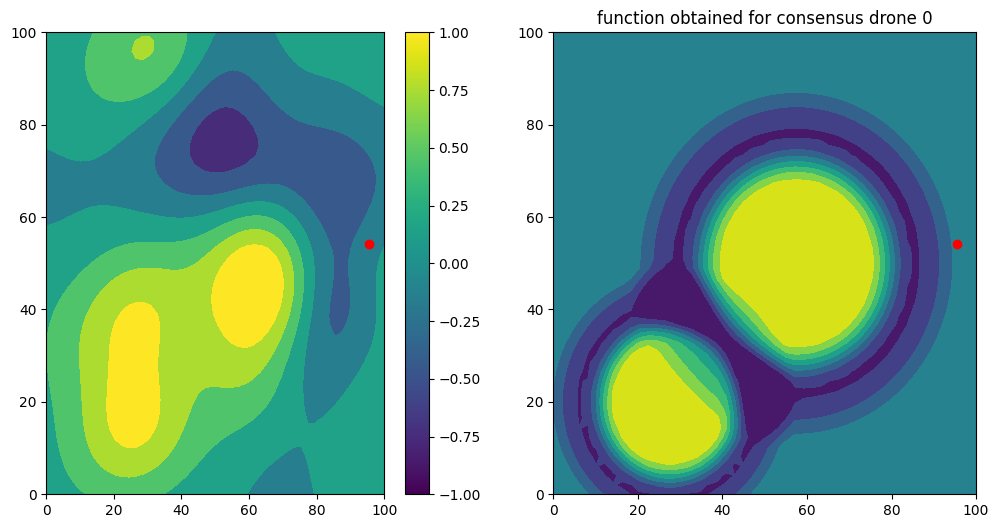

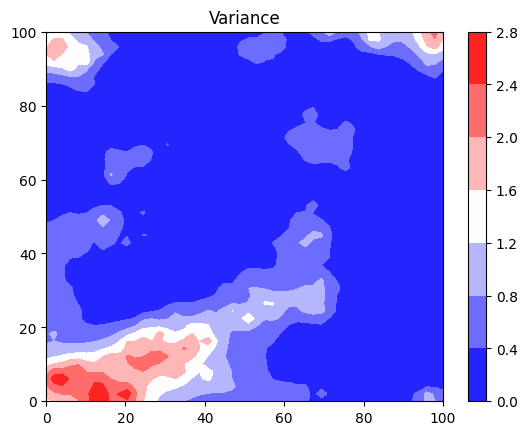

step


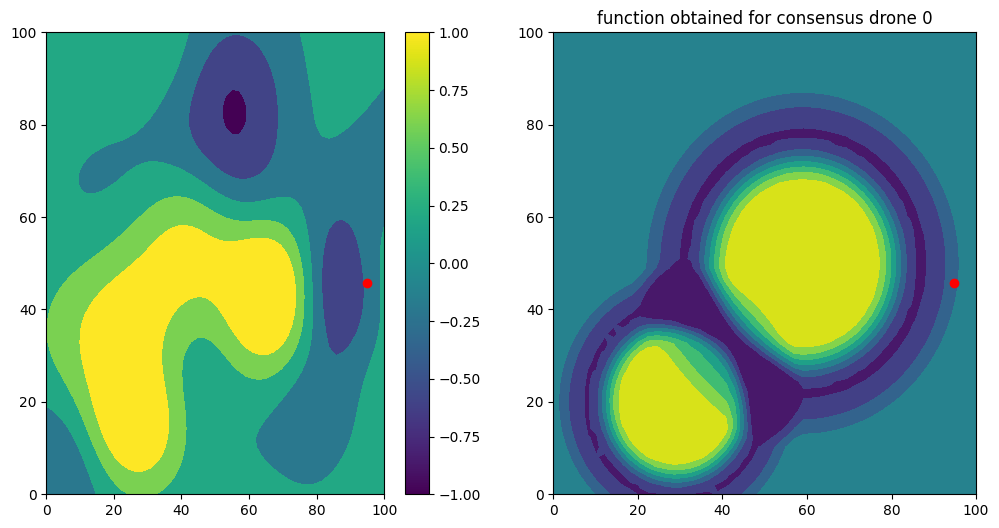

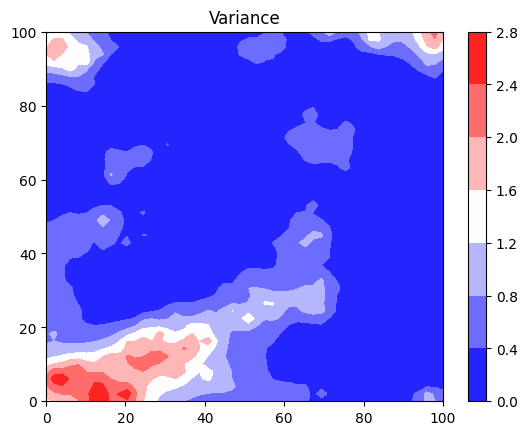

step


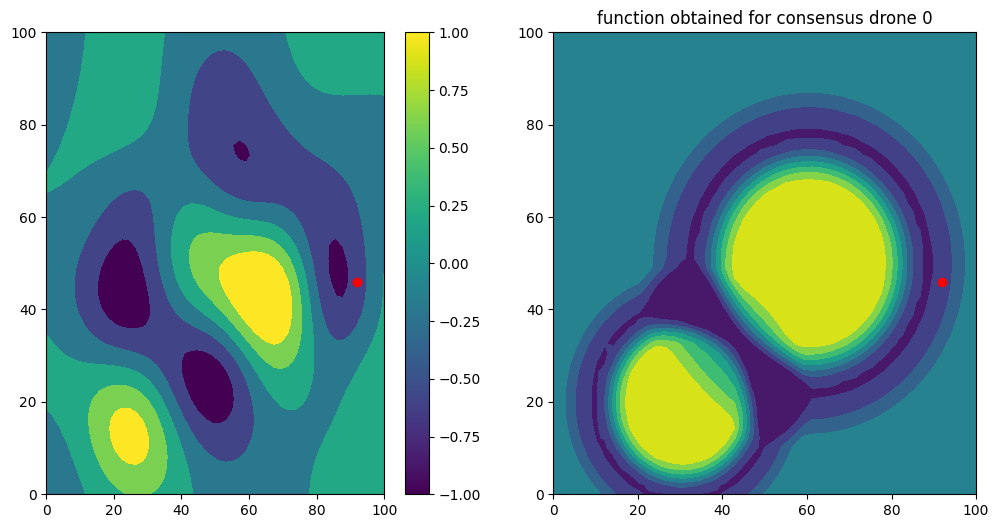

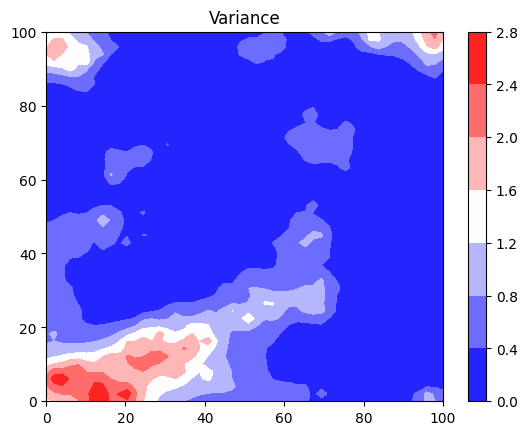

step


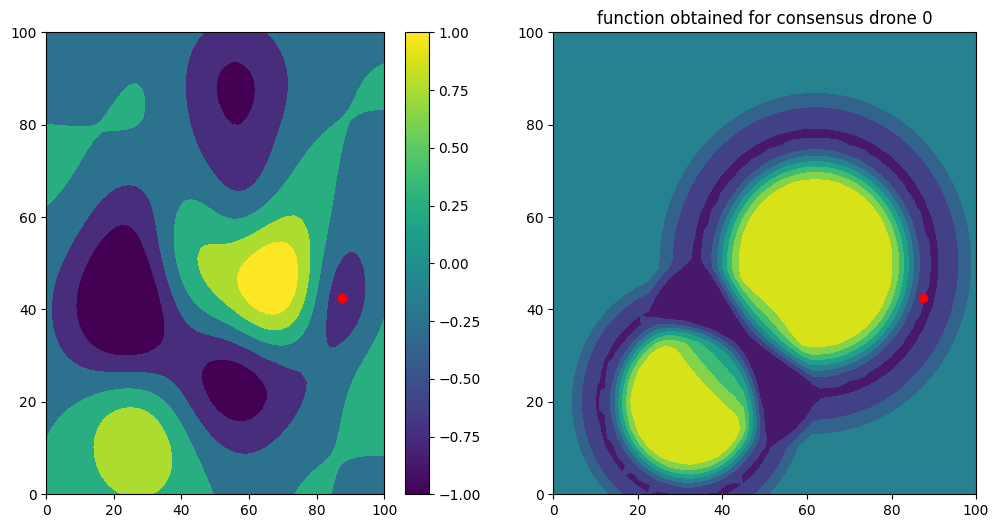

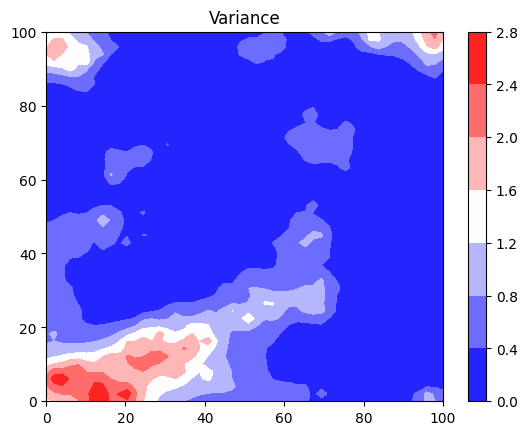

step


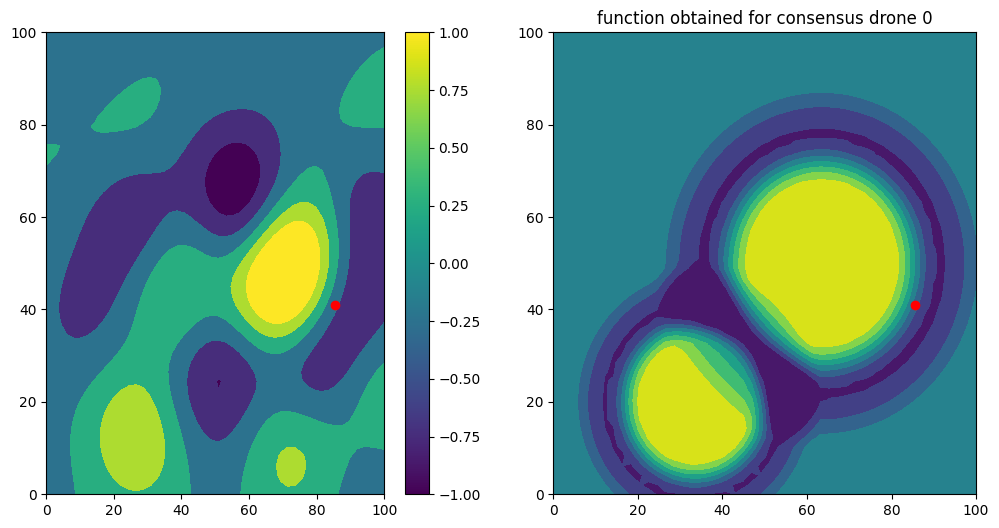

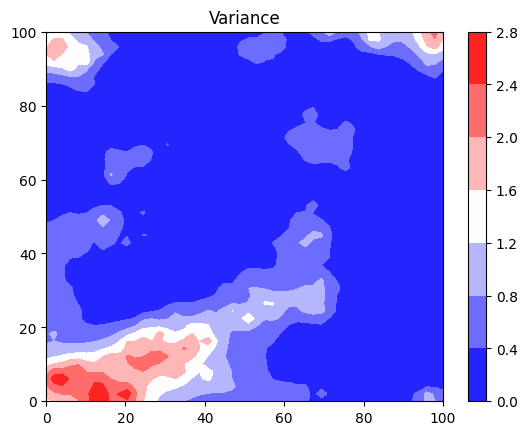

step


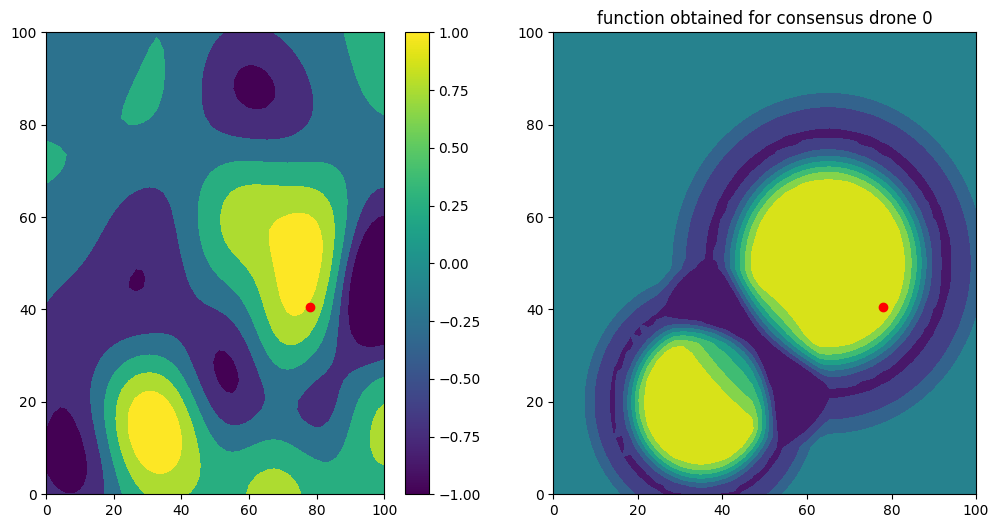

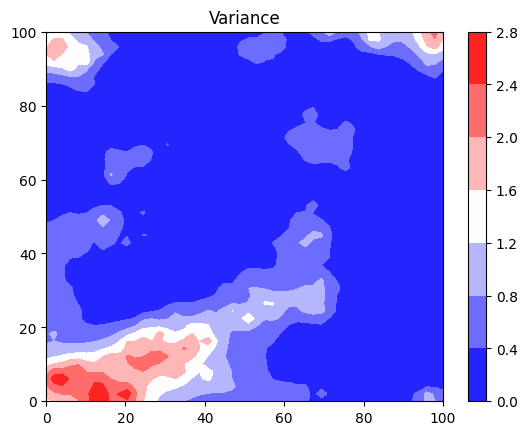

step


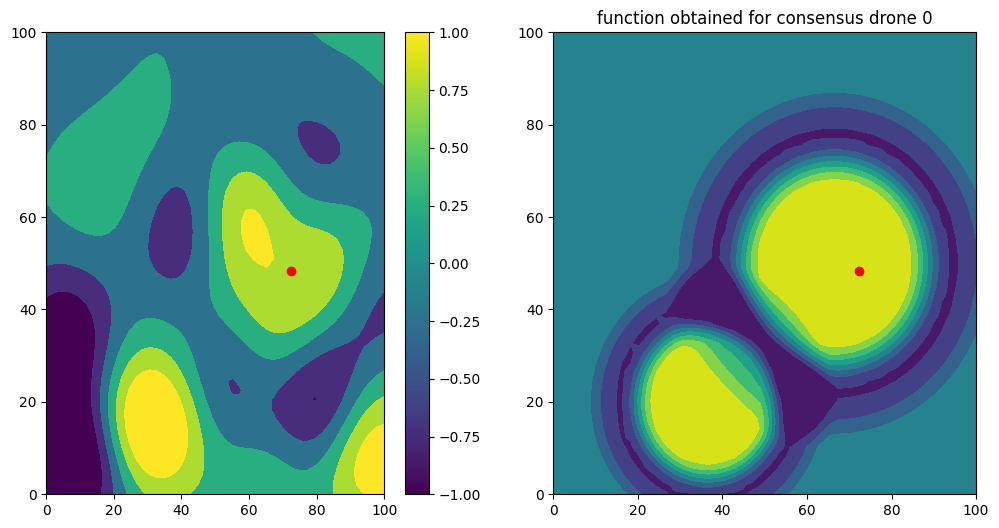

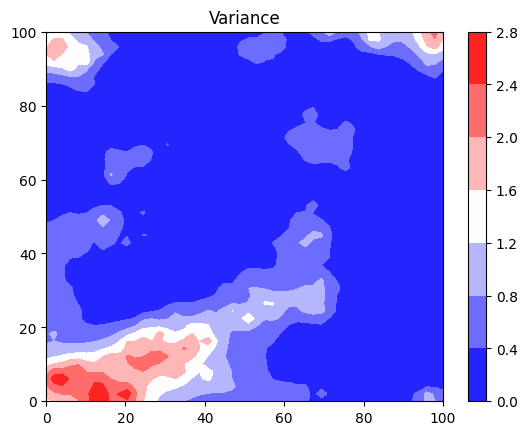

step


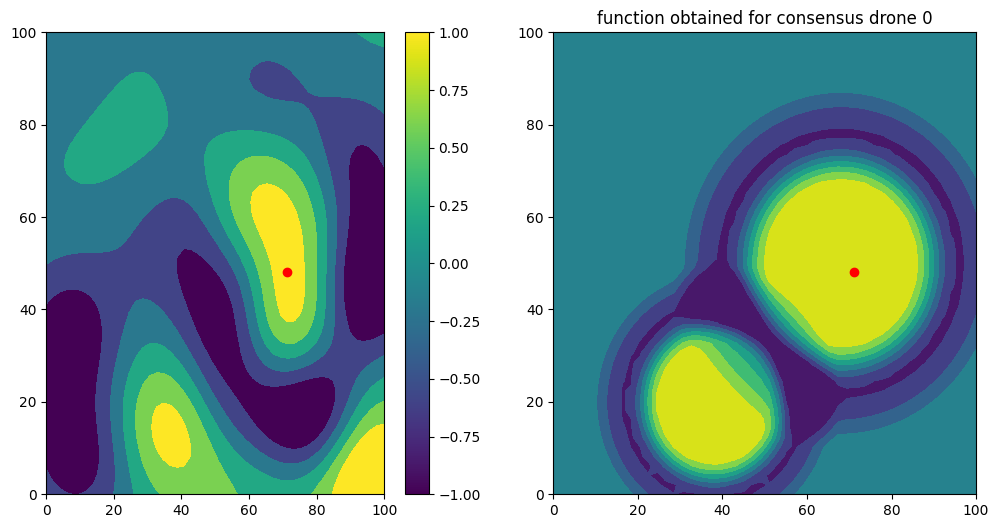

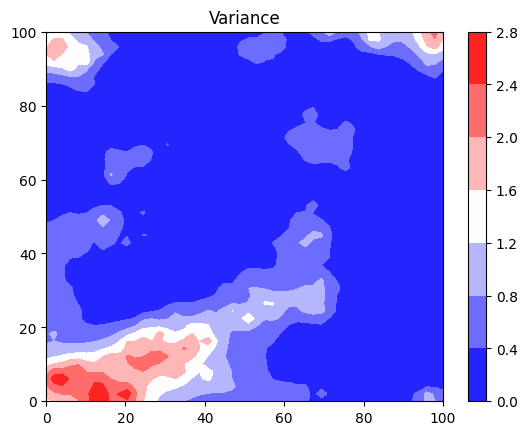

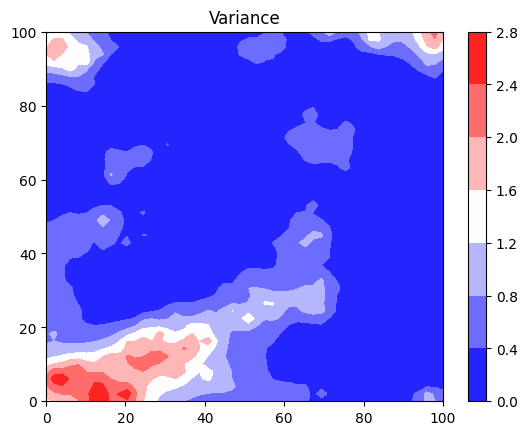

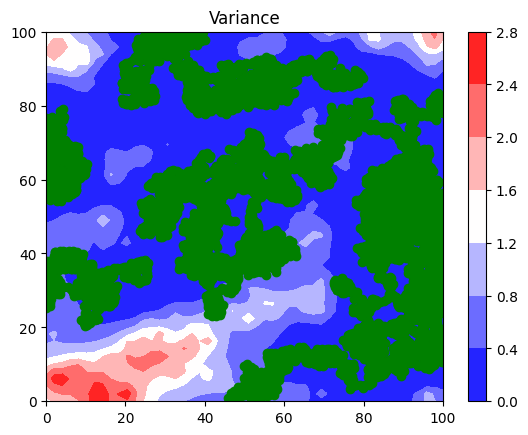

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors

length_scale_2 = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel
# Kernel
sigma_n = 0
length_scale = 20
seed = 0
E = 300

m = 1000 # 1000
E = 300  # 100
l = 300 # 1000

wind_direction_clouds = np.array([1,0])

kernel_2 = RBF(length_scale_2, length_scale_bounds="fixed")
# kernel_2 = ConstantKernel(sigma_n, constant_value_bounds="fixed") + RBF(length_scale, length_scale_bounds="fixed")
kernel = ConstantKernel(sigma_n, constant_value_bounds="fixed") + Matern(length_scale, length_scale_bounds=(1e-05, 100.0), nu=0.5)

print("numero droni ", num_drones)
drones = [Kalman_drone(position=drone_positions[i], area_size=area_size, kernel=kernel, E = E, seed = 0) for i in range(num_drones)]
drones_noK = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = 1, E = E, l = l, sigma= sigma_s, length_scale=length_scale) for i in range(num_drones)]
# Create a 3D grid for x, y, and z
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
# z = np.linspace(margin, area_size, 50)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y, z)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
# Calculate the true function values
wind = wind_field_2d(XY, clouds_2d, 0, wind_direction_clouds).reshape(xv.shape)

sample_points = []
sample_points_n = []

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

def build_matrix(drones):
  # gamma = 0.4  # consensus rate
  max_distance = 200

  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones) #* ((1- gamma))
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  # num_neighbors = np.sum(adjacency_matrix, axis=1)
  # Avoid division by zero by setting num_neighbors to 1 where it is zero
  # num_neighbors[num_neighbors == 0] = 1
  matrix = (adjacency_matrix + matrix)
  return matrix

# #BUILD adjacency matrix:
adjacency = build_matrix(drones)
print("adjacency ", adjacency)

print_Eig = False #bool to print eigenvalues and eigenvectors
if print_Eig:
  print("adjacency")
  print(adjacency)
  print("eigenvalues = ", )
  print("left eigenvector")
  print(scipy.linalg.eig(adjacency, left=True))

Ps = np.zeros((num_drones, E*E))
# Ps2 = np.zeros((num_drones, E*E))
thetas = np.zeros((num_drones, E))

for step in range(601):
  #CASE distributed moving
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.kalman_update(X_new, y_new)
        drone.move()
  elif step % 1 == 0:
    for drone in drones:
        X_new, y_new = drone.collect_data(step)
        drone.kalman_update(X_new, y_new)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drone.move()
  else:
    for drone in drones:
        drone.move()

  if step % 50 == 0:

    print("Kalman update")
    Z_pred = drones[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    print(f"step {step}")
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    # Visualize the positions
    plt.figure(figsize=(16, 6))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, Z_true, cmap='coolwarm')
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    # plt.colorbar(contour)
    plt.title(f'GT')

    ax = plt.subplot(1,3,2)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    # sampled_points_a = np.vstack(sample_points)
    # plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    colormap = plt.cm.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=-1, vmax=1)
    cbar = plt.colorbar(sm, ax=ax)
    plt.clim(-1, 1)
    plt.title(f'function obtained for consensus drone 0')

    plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title('Variance')
    plt.show()

  adjacency = build_matrix(drones)
  for i in range(num_drones):
    Ps[i,:] = np.linalg.inv(drones[i].P).flatten()
    # Ps2[i,:] = (np.linalg.inv(drones[i].P)@ np.linalg.inv(drones[i].P)).flatten()
    # print("compressed alpha ", alphas)
    thetas[i,:] = (np.linalg.inv(drones[i].P) @ drones[i].theta).flatten()

  # Ps = adjacency @ Ps / np.repeat(np.expand_dims(np.sum(adjacency, axis=0), axis=-1), E**2, axis=1)
  #   # Ps2 = adjacency @ Ps2
  # thetas = adjacency @ thetas / np.repeat(np.expand_dims(np.sum(adjacency, axis=0), axis=-1), E, axis=1)

  Ps = adjacency @ Ps
    # Ps2 = adjacency @ Ps2
  thetas = adjacency @ thetas

  for i in range(num_drones):
    drones[i].P = np.linalg.inv(Ps[i,:].reshape((E,E))/np.sum(adjacency[i,:]))
    #drones[i].P = np.linalg.inv(Ps[i,:].reshape((E,E)))
    drones[i].theta = np.linalg.inv(Ps[i,:].reshape((E,E))) @ thetas[i,:].reshape((E,1))

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

for step in range(601):
  #CASE distributed moving
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.update_gp()
        drone.move()
  elif step % 5 == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        # x_repr, y_repr = representative_points(X_new, drone)
        drone.moving_update(X_new, y_new, r = 0.5)
        # for k in range(x_repr.shape[0]):
        #   # print(f"x repr {x_repr[k,:]}")
        #   # print(f"y repr {y_repr[k]}")
        #   x_new.append(x_repr[k,:].copy())
        #   # print(f" repr point {x_repr[k,:]} : y = {y_repr[k]}")
        #   drone.moving_update(x_repr[k,:].reshape(1,2), y_repr[k], r = 0.5)
        # drone.move()
  else:
    for drone in drones_noK:
        drone.move()

  if step % 50 == 0:
    plt.figure(figsize=(12, 6))
    Z_pred = drones_noK[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    print("step")
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    # Visualize the positions
    plt.subplot(1,2,1)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    # sampled_points_a = np.vstack(sample_points)
    # plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    cbar = plt.colorbar()
    plt.clim(-1, 1)

    plt.subplot(1,2,2)
    plt.contourf(X, Y, Z_true, cmap='viridis')
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    # plt.colorbar(contour)
    plt.title(f'function obtained for consensus drone 0')
    plt.show()

    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title('Variance')
    plt.show()

  if step % 50 == 0:
    adjacency = build_matrix(drones_noK)
    for i in range(num_drones):
      alphas[i,:] = drones_noK[i].alpha.flatten()
      # print("compressed alpha ", alphas)
      bhetas[i,:] = drones_noK[i].beta.flatten()

    alphas_old = alphas.copy()
    bhetas_old = bhetas.copy()

    alphas = adjacency @ alphas
    bhetas = adjacency @ bhetas
    for i in range(num_drones):
      drones_noK[i].alpha = alphas[i,:].reshape((E,E))
      # print("drone alpha ", drones[1].alpha)
      drones_noK[i].beta = bhetas[i,:].reshape((E,1))

x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
xv, yv = np.meshgrid(x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
v_pred = drones[0].variance(XY)
v_pred = v_pred.reshape(xv.shape)
contour = plt.contourf(xv, yv, v_pred, cmap='bwr')
# plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
# plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()

# for drone in drones:
#   Z_pred = drone.predict(XY)
#   Z_pred = Z_pred.reshape(X.shape)

#   # Visualize the positions

#   count = plt.contourf(X, Y, Z_pred, cmap='viridis')
#   plt.scatter(drone.position[0], drone.position[1], c='red', label='Drone')
#   plt.colorbar(count)
#   plt.title(f'function obtained for consensus drone 0')
#   plt.show()
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
sampled_points = np.vstack(sample_points)
xv, yv = np.meshgrid(x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
v_pred = drones[0].variance(XY)
v_pred = v_pred.reshape(xv.shape)
contour = plt.contourf(xv, yv, v_pred, cmap='bwr')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c='green', label='Drones')
# plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()

# for drone in drones:
#   drone.map_f = changed_function

# x_new = []
# drones[0].position = np.array([20,10])
# drone = drones[0]

# for step in range(10):
#   #CASE distributed moving
#   # Simulate the drones collecting data and updating the GP
#   if step % 1 == 0:
#     # for drone in drones:
#     X_new, y_new = drone.collect_data()
#     drone.kalman_update(X_new, y_new)

# Z_pred = drone.predict(XY)
# Z_pred = Z_pred.reshape(X.shape)
# # Visualize the positions
# contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
# plt.colorbar(contour)
# plt.title(f'KF drone step {step}')
# plt.show()

# v_pred = drone.variance(XY)
# v_pred = v_pred.reshape(X.shape)
# contour = plt.contourf(X, Y, v_pred, cmap='bwr')
# plt.colorbar(contour)
# plt.title(f'KF drone Variance {step}')
# plt.show()

## Distributed Kalman drones (withouth /N factor) comparisons

numero droni  16
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
min{ lambda } =  3.5518228429942893e-11
adjacency  [[0.0625 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.0625 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0625 0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0

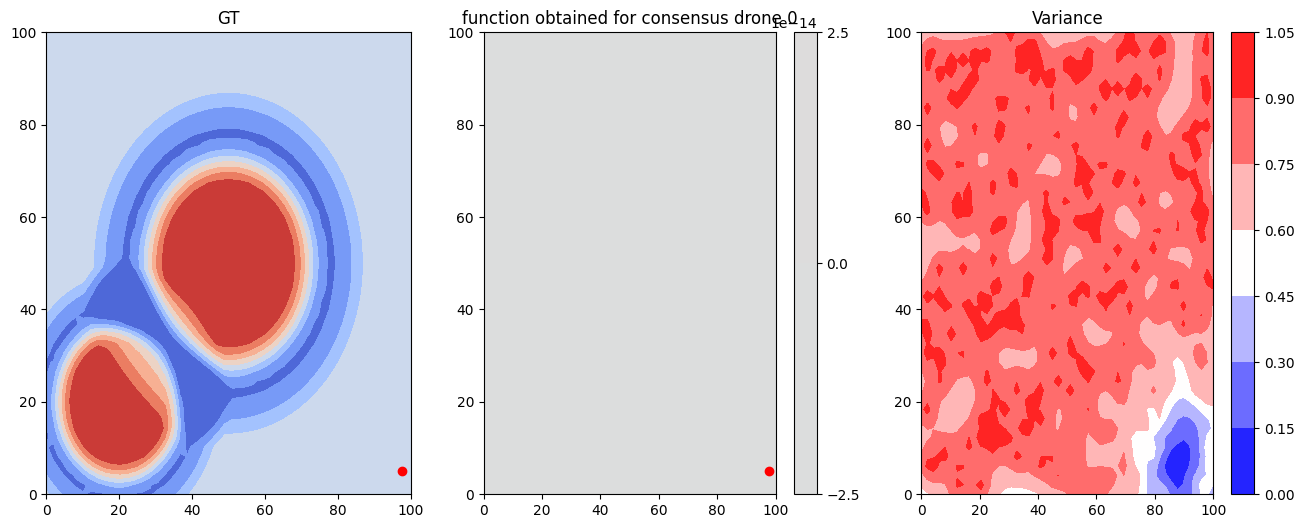

<ipython-input-12-eef3decae39c>:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')
<ipython-input-12-eef3decae39c>:198: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')
<ipython-input-12-eef3decae39c>:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm')


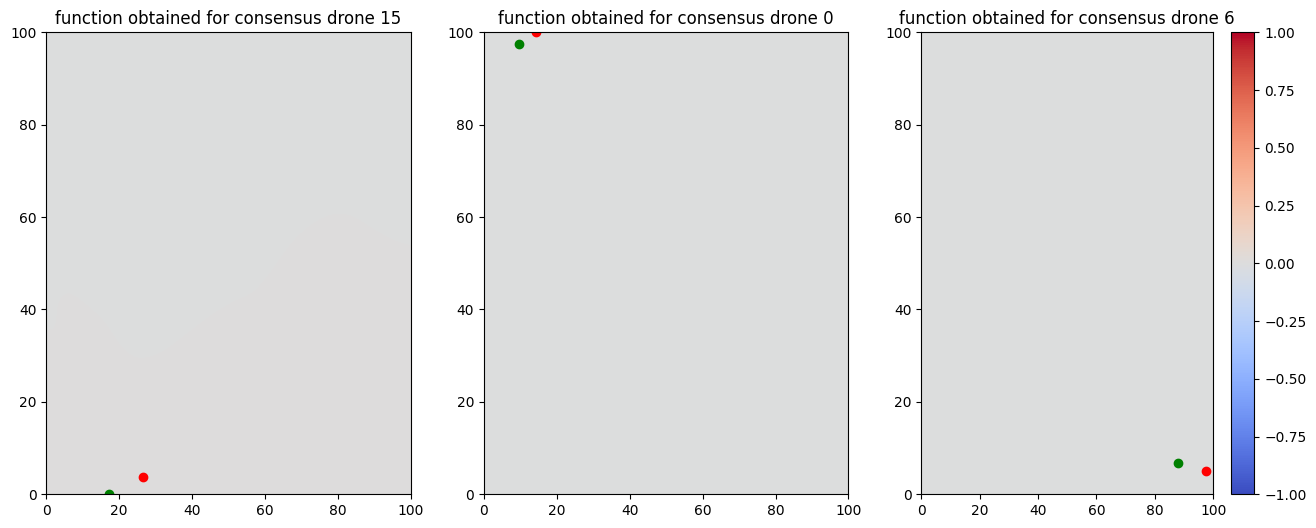

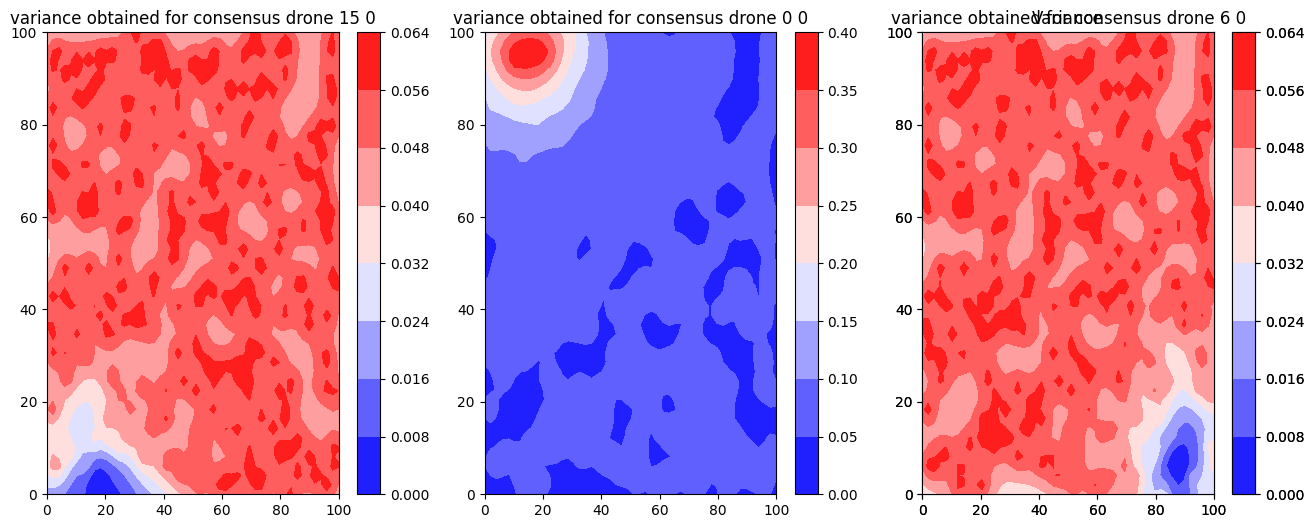

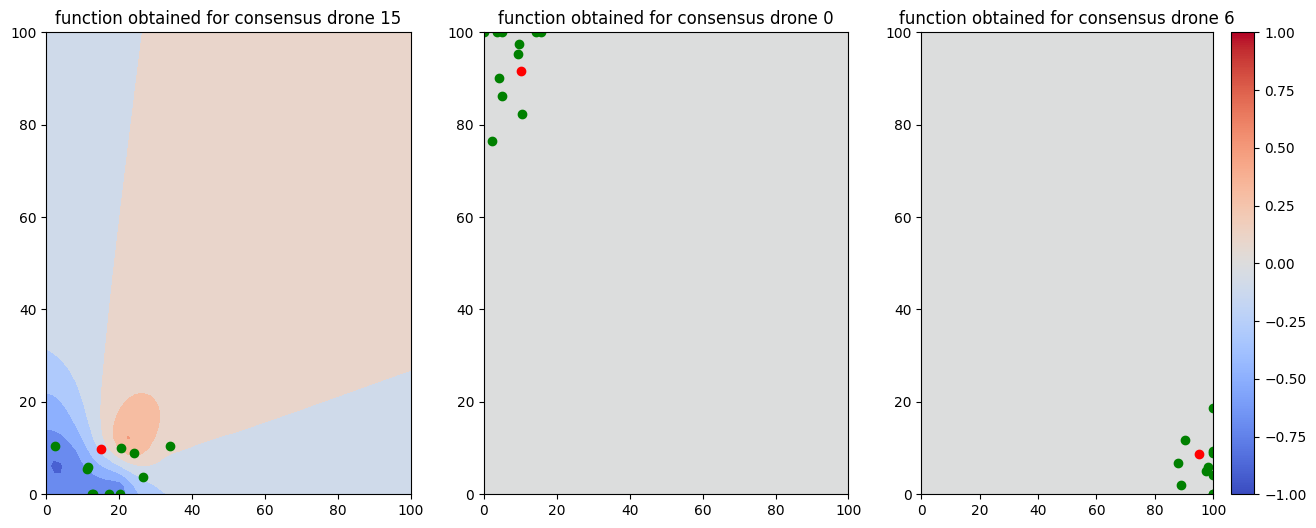

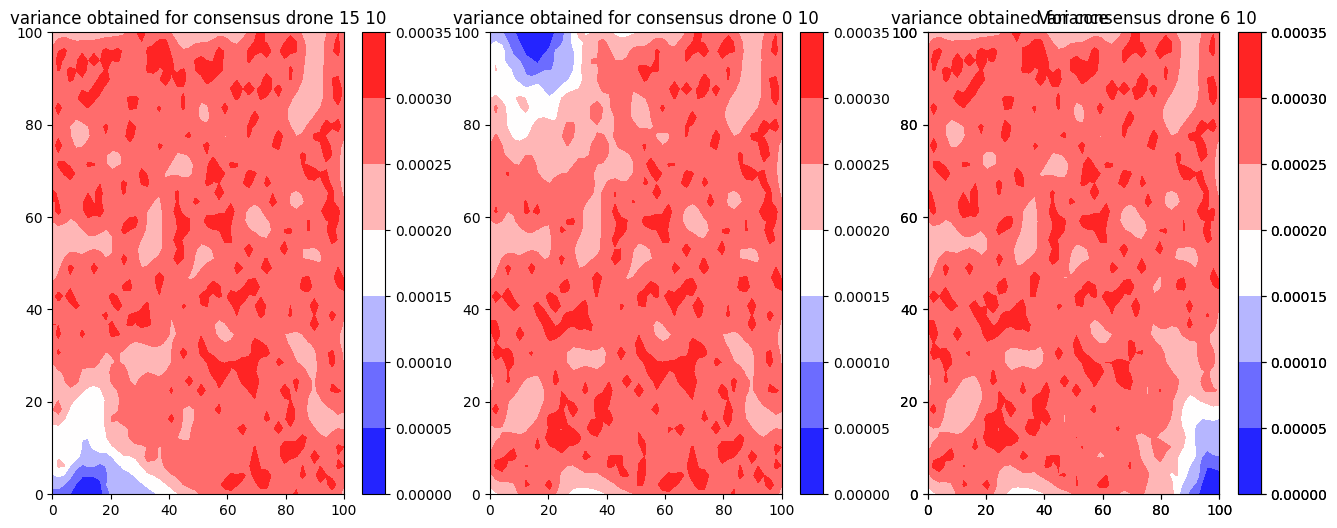

KeyboardInterrupt: 

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
import scipy
import matplotlib.colors as mcolors

def stable_inversion(matrix):
  # inv = np.linalg.inv(matrix)
  threshold = 1e-2
  inv = np.linalg.pinv(matrix, rcond=threshold)
  return inv

length_scale_2 = 10
sigma_kernel = 1e-2 # 1
sigma_s = sigma_kernel
# Kernel
sigma_n = 0
length_scale = 20
seed = 0
E = 300

step_size = 10

m = 1000 # 1000
E = 300  # 100
l = 300 # 1000

kernel_2 = RBF(length_scale_2, length_scale_bounds="fixed")
# kernel_2 = ConstantKernel(sigma_n, constant_value_bounds="fixed") + RBF(length_scale, length_scale_bounds="fixed")
kernel = ConstantKernel(sigma_n, constant_value_bounds="fixed") + Matern(length_scale, length_scale_bounds=(1e-05, 100.0), nu=0.5)

print("numero droni ", num_drones)
drones = [Kalman_drone(position=drone_positions[i], area_size=area_size, kernel=kernel, E = E, seed = 0) for i in range(num_drones)]
drones_noK = [Drone(position=drone_positions[i], area_size=area_size, kernel=kernel_2, num_drones = 1, E = E, l = l, sigma= sigma_s, length_scale=length_scale) for i in range(num_drones)]
# Create a 3D grid for x, y, and z
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
# z = np.linspace(margin, area_size, 50)

xv, yv = np.meshgrid(x, y)

# Initial positions of drones (x, y, z)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
# Calculate the true function values
wind = wind_field_2d(XY, clouds_2d, 0, wind_direction_clouds).reshape(xv.shape)

sample_points = []
sample_points_n = []

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

def build_matrix(drones):
  # gamma = 0.4  # consensus rate
  max_distance = 1 # 60

  adjacency_matrix = np.zeros((num_drones, num_drones))
  matrix = np.eye(num_drones) #* ((1- gamma))
  positions = np.array([drone.position for drone in drones])
  # Compute pairwise distances
  distances = np.linalg.norm(positions[:, np.newaxis] - positions, axis=2)
  adjacency_matrix[distances <= max_distance] = 1
  adjacency_matrix[distances == 0] = 0
  # num_neighbors = np.sum(adjacency_matrix, axis=1)
  # Avoid division by zero by setting num_neighbors to 1 where it is zero
  # num_neighbors[num_neighbors == 0] = 1
  matrix = (adjacency_matrix + matrix)
  return matrix

# #BUILD adjacency matrix:
adjacency = build_matrix(drones)
print("adjacency ", adjacency / 16)

print_Eig = False #bool to print eigenvalues and eigenvectors
if print_Eig:
  print("adjacency")
  print(adjacency)
  print("eigenvalues = ", )
  print("left eigenvector")
  print(scipy.linalg.eig(adjacency, left=True))

P_tildes = np.zeros((num_drones, E*E))
# Ps2 = np.zeros((num_drones, E*E))
Ls = np.zeros((num_drones, E))

drones_trajectories = [[] for _ in range(num_drones)]

for step in range(601):
  #CASE distributed moving
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for i,drone in enumerate(drones):
        X_new, y_new = drone.collect_data(step)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drones_trajectories[i].append(np.array([X_new[0][0], X_new[0][1]]))
        drone.kalman_update(X_new, y_new)
        drone.move(step_size=step_size)
  elif step % 1 == 0:
    for i,drone in enumerate(drones):
        X_new, y_new = drone.collect_data(step)
        drone.kalman_update(X_new, y_new)
        sample_points.append(np.array([X_new[0][0], X_new[0][1]]))
        drones_trajectories[i].append(np.array([X_new[0][0], X_new[0][1]]))
        drone.move(step_size=step_size)
  else:
    for drone in drones:
        drone.move(step_size=step_size)

  if step % 50 == 0:


    Z_pred = drones[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    print(f"step {step}")
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    # Visualize the positions
    plt.figure(figsize=(16, 6))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, Z_true, cmap='coolwarm')
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    # plt.colorbar(contour)
    plt.title(f'GT')

    ax = plt.subplot(1,3,2)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    # sampled_points_a = np.vstack(sample_points)
    # plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    # colormap = plt.cm.get_cmap('coolwarm')
    # sm = plt.cm.ScalarMappabl(cmap=colormap)
    # sm.set_clim(vmin=-1, vmax=1)
    cbar = plt.colorbar(contour)
    plt.clim(-1, 1)
    plt.title(f'function obtained for consensus drone 0')

    plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title('Variance')
    plt.show()

  # Communication

  adjacency = build_matrix(drones)
  for i in range(num_drones):
    P_tildes[i,:] = stable_inversion(drones[i].P).flatten()
    # Ls[i,:] = (np.linalg.solve(drones[i].P, drones[i].theta)).flatten()
    Ls[i,:] = (stable_inversion(drones[i].P) @ drones[i].theta).flatten()

  for i in range(10):
    P_sum = adjacency @ P_tildes
    Ls_sum = adjacency @ Ls
    for i in range(num_drones):
      P_tildes[i,:] = P_sum[i,:] / np.sum(adjacency[i,:],axis=0)
      Ls[i,:] = Ls_sum[i,:] / np.sum(adjacency[i,:],axis=0)

  for i in range(num_drones):
    drones[i].P = stable_inversion(P_tildes[i,:].reshape((E,E))) / num_drones
    # drones[i].theta = np.linalg.solve(P_tildes[i,:].reshape((E,E)), Ls[i,:]).reshape((E,1))
    drones[i].theta = (stable_inversion(P_tildes[i,:].reshape((E,E))) @ Ls[i,:]).reshape((E,1))

  if (step % 10 == 0) and (step < 50):
    Z_pred_6 = drones[6].predict(XY)
    Z_pred_15 = drones[15].predict(XY)
    Z_pred_0 = drones[0].predict(XY)
    Z_pred_15 = Z_pred_15.reshape(X.shape)
    Z_pred_6 = Z_pred_6.reshape(X.shape)
    Z_pred_0 = Z_pred_0.reshape(X.shape)

    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot(1,3,1)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred_15, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    sampled_points_a = np.vstack(sample_points)
    #plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    drones_trajectories_a = np.vstack(drones_trajectories[15])
    plt.scatter(drones_trajectories_a[:, 0], drones_trajectories_a[:, 1], c='green', label='Drones')
    plt.scatter(drones[15].position[0], drones[15].position[1], c='red', label='Drone')
    colormap = plt.cm.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=-1, vmax=1)
    # cbar = plt.colorbar(sm, ax=ax)
    plt.clim(-1, 1)
    plt.title(f'function obtained for consensus drone 15')

    ax = plt.subplot(1,3,2)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred_0, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    sampled_points_a = np.vstack(sample_points)
    #plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    drones_trajectories_a = np.vstack(drones_trajectories[0])
    plt.scatter(drones_trajectories_a[:, 0], drones_trajectories_a[:, 1], c='green', label='Drones')
    plt.scatter(drones[0].position[0], drones[0].position[1], c='red', label='Drone')
    colormap = plt.cm.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=-1, vmax=1)
    # cbar = plt.colorbar(sm, ax=ax)
    plt.clim(-1, 1)
    plt.title(f'function obtained for consensus drone 0')

    ax = plt.subplot(1,3,3)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred_6, cmap='coolwarm', norm = norm, vmin=-1, vmax=1)
    sampled_points_a = np.vstack(sample_points)
    #plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    drones_trajectories_a = np.vstack(drones_trajectories[6])
    plt.scatter(drones_trajectories_a[:, 0], drones_trajectories_a[:, 1], c='green', label='Drones')
    plt.scatter(drones[6].position[0], drones[6].position[1], c='red', label='Drone')
    colormap = plt.cm.get_cmap('coolwarm')
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=-1, vmax=1)
    cbar = plt.colorbar(sm, ax=ax)
    plt.clim(-1, 1)
    plt.title(f'function obtained for consensus drone 6')

    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot(1,3,1)
    v_pred = drones[15].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    plt.colorbar(contour)
    plt.title(f'variance obtained for consensus drone 15 {step}')

    ax = plt.subplot(1,3,2)
    v_pred = drones[0].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title(f'variance obtained for consensus drone 0 {step}')

    ax = plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title(f'variance obtained for consensus drone 6 {step}')


    plt.subplot(1,3,3)
    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title('Variance')
    plt.show()

alphas = np.zeros((num_drones, E*E))
bhetas = np.zeros((num_drones, E))

for step in range(601):
  #CASE distributed moving
  # Simulate the drones collecting data and updating the GP
  if step == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        drone.update_gp()
        drone.move()
  elif step % 5 == 0:
    for drone in drones_noK:
        X_new, y_new = drone.collect_data(step)
        # x_repr, y_repr = representative_points(X_new, drone)
        drone.moving_update(X_new, y_new, r = 0.5)
        # for k in range(x_repr.shape[0]):
        #   # print(f"x repr {x_repr[k,:]}")
        #   # print(f"y repr {y_repr[k]}")
        #   x_new.append(x_repr[k,:].copy())
        #   # print(f" repr point {x_repr[k,:]} : y = {y_repr[k]}")
        #   drone.moving_update(x_repr[k,:].reshape(1,2), y_repr[k], r = 0.5)
        # drone.move()
  else:
    for drone in drones_noK:
        drone.move()

  if step % 50 == 0:
    plt.figure(figsize=(12, 6))
    Z_pred = drones_noK[6].predict(XY)
    Z_pred = Z_pred.reshape(X.shape)
    print("step")
    Z_true = wind_field_2d(XY, clouds_2d, step, wind_direction_clouds).reshape(X.shape)
    # Visualize the positions
    plt.subplot(1,2,1)
    norm = mcolors.Normalize(vmin=-1, vmax=1, clip=True)
    contour = plt.contourf(X, Y, Z_pred, cmap='viridis', norm = norm, vmin=-1, vmax=1)
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    # sampled_points_a = np.vstack(sample_points)
    # plt.scatter(sampled_points_a[:, 0], sampled_points_a[:, 1], c='green', label='Drones')
    cbar = plt.colorbar()
    plt.clim(-1, 1)

    plt.subplot(1,2,2)
    plt.contourf(X, Y, Z_true, cmap='viridis')
    plt.scatter(drones_noK[6].position[0], drones_noK[6].position[1], c='red', label='Drone')
    # plt.colorbar(contour)
    plt.title(f'function obtained for consensus drone 0')
    plt.show()

    v_pred = drones[6].variance(XY)
    v_pred = v_pred.reshape(X.shape)
    contour = plt.contourf(X, Y, v_pred, cmap='bwr')
    # plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
    # plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
    plt.colorbar(contour)
    plt.title('Variance')
    plt.show()

  if step % 50 == 0:
    adjacency = build_matrix(drones_noK)
    for i in range(num_drones):
      alphas[i,:] = drones_noK[i].alpha.flatten()
      # print("compressed alpha ", alphas)
      bhetas[i,:] = drones_noK[i].beta.flatten()

    alphas_old = alphas.copy()
    bhetas_old = bhetas.copy()

    alphas = adjacency @ alphas
    bhetas = adjacency @ bhetas
    for i in range(num_drones):
      drones_noK[i].alpha = alphas[i,:].reshape((E,E))
      # print("drone alpha ", drones[1].alpha)
      drones_noK[i].beta = bhetas[i,:].reshape((E,1))

x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
xv, yv = np.meshgrid(x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
v_pred = drones[0].variance(XY)
v_pred = v_pred.reshape(xv.shape)
contour = plt.contourf(xv, yv, v_pred, cmap='bwr')
# plt.scatter(drone_positions[:, 0], drone_positions[:, 1], c='red', label='Drones')
# plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()

# for drone in drones:
#   Z_pred = drone.predict(XY)
#   Z_pred = Z_pred.reshape(X.shape)

#   # Visualize the positions

#   count = plt.contourf(X, Y, Z_pred, cmap='viridis')
#   plt.scatter(drone.position[0], drone.position[1], c='red', label='Drone')
#   plt.colorbar(count)
#   plt.title(f'function obtained for consensus drone 0')
#   plt.show()
x = np.linspace(0, area_size, 50)
y = np.linspace(0, area_size, 50)
sampled_points = np.vstack(sample_points)
xv, yv = np.meshgrid(x, y)
XY = np.vstack([xv.ravel(), yv.ravel()]).T
v_pred = drones[0].variance(XY)
v_pred = v_pred.reshape(xv.shape)
contour = plt.contourf(xv, yv, v_pred, cmap='bwr')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c='green', label='Drones')
# plt.scatter(drone_positions[0, 0], drone_positions[0, 1], c='blue', label='Drone 0')
plt.colorbar(contour)
plt.title('Variance')
plt.show()

# for drone in drones:
#   drone.map_f = changed_function

# x_new = []
# drones[0].position = np.array([20,10])
# drone = drones[0]

# for step in range(10):
#   #CASE distributed moving
#   # Simulate the drones collecting data and updating the GP
#   if step % 1 == 0:
#     # for drone in drones:
#     X_new, y_new = drone.collect_data()
#     drone.kalman_update(X_new, y_new)

# Z_pred = drone.predict(XY)
# Z_pred = Z_pred.reshape(X.shape)
# # Visualize the positions
# contour = plt.contourf(X, Y, Z_pred, cmap='viridis')
# plt.colorbar(contour)
# plt.title(f'KF drone step {step}')
# plt.show()

# v_pred = drone.variance(XY)
# v_pred = v_pred.reshape(X.shape)
# contour = plt.contourf(X, Y, v_pred, cmap='bwr')
# plt.colorbar(contour)
# plt.title(f'KF drone Variance {step}')
# plt.show()

# Utils

In [ ]:
fig = plt.figure()
Z_pred = Z_pred / np.linalg.norm(Z_pred)
Z_true = Z_true / np.linalg.norm(Z_true)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='plasma')
ax.plot_surface(X, Y, Z_true - Z_pred, cmap='magma')
ax.set_title('True Function Values')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z_true')
plt.show()

In [ ]:
max_pred = np.max(Z_pred)
print(max_pred)
max_true = np.max(Z_true)
print(max_true)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite
from scipy.linalg import eigh

# Define parameters
sigma = 1.0
num_eigenfunctions = 6

# Define the Gaussian kernel function
def gaussian_kernel(x, y, sigma):
    return np.exp(-(x - y)**2 / (2 * sigma**2))

# Calculate eigenfunctions (Hermite functions) and eigenvalues
x_vals = np.linspace(-5, 5, 100)
eigenvalues = []
eigenfunctions = []

for n in range(num_eigenfunctions):
    Hn = hermite(n)
    phi_n = (1 / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi) * sigma)) * Hn(x_vals / sigma) * np.exp(-x_vals**2 / (2 * sigma**2))
    lambda_n = sigma * np.sqrt(np.pi) * np.exp(-n/2)

    eigenvalues.append(lambda_n)
    eigenfunctions.append(phi_n)

# Plot the eigenfunctions
plt.figure(figsize=(12, 8))
for i, phi in enumerate(eigenfunctions):
    plt.plot(x_vals, phi, label=f'n={i}, λ={eigenvalues[i]:.2f}')
plt.title('Eigenfunctions of Gaussian Kernel')
plt.xlabel('x')
plt.ylabel('Eigenfunction value')
plt.legend()
plt.grid(True)
plt.show()

# Print eigenvalues
for i, lambda_n in enumerate(eigenvalues):
    print(f"Eigenvalue λ_{i} = {lambda_n:.2f}")
